<a href="https://colab.research.google.com/github/Jiaming0906/Hungry-Games/blob/master/EDA_compilation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import lightgbm as lgbm
from sklearn.model_selection import train_test_split
from sklearn.metrics import *
import warnings

pd.set_option('display.max_columns', 65)
# sns.set()

warnings.filterwarnings('ignore')

C:\Users\hongx\anaconda3\lib\site-packages\dask\dataframe\utils.py:366: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)
C:\Users\hongx\anaconda3\lib\site-packages\dask\dataframe\utils.py:366: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)
C:\Users\hongx\anaconda3\lib\site-packages\dask\dataframe\utils.py:366: FutureWarning: pandas.UInt64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)


In [ ]:
data_2018_full = pd.read_excel("2018-v262-16112021-EU MRV Publication of information.xlsx", skiprows = 2)
data_2019_full = pd.read_excel("2019-v197-09032022-EU MRV Publication of information.xlsx", skiprows = 2)
data_2020_full = pd.read_excel("2020-v121-09032022-EU MRV Publication of information.xlsx", skiprows = 2)

In [ ]:
data_2020_full.head()

,IMO Number,Name,Ship type,Reporting Period,Technical efficiency,Port of Registry,Home Port,Ice Class,DoC issue date,DoC expiry date,Verifier Number,Verifier Name,Verifier NAB,Verifier Address,Verifier City,Verifier Accreditation number,Verifier Country,A,B,C,D,Total fuel consumption [m tonnes],Fuel consumptions assigned to On laden [m tonnes],Total CO₂ emissions [m tonnes],CO₂ emissions from all voyages between ports under a MS jurisdiction [m tonnes],CO₂ emissions from all voyages which departed from ports under a MS jurisdiction [m tonnes],CO₂ emissions from all voyages to ports under a MS jurisdiction [m tonnes],CO₂ emissions which occurred within ports under a MS jurisdiction at berth [m tonnes],CO₂ emissions assigned to Passenger transport [m tonnes],CO₂ emissions assigned to Freight transport [m tonnes],CO₂ emissions assigned to On laden [m tonnes],Annual Time spent at sea [hours],Annual average Fuel consumption per distance [kg / n mile],Annual average Fuel consumption per transport work (mass) [g / m tonnes · n miles],Annual average Fuel consumption per transport work (volume) [g / m³ · n miles],Annual average Fuel consumption per transport work (dwt) [g / dwt carried · n miles],Annual average Fuel consumption per transport work (pax) [g / pax · n miles],Annual average Fuel consumption per transport work (freight) [g / m tonnes · n miles],Annual average CO₂ emissions per distance [kg CO₂ / n mile],Annual average CO₂ emissions per transport work (mass) [g CO₂ / m tonnes · n miles],Annual average CO₂ emissions per transport work (volume) [g CO₂ / m³ · n miles],Annual average CO₂ emissions per transport work (dwt) [g CO₂ / dwt carried · n miles],Annual average CO₂ emissions per transport work (pax) [g CO₂ / pax · n miles],Annual average CO₂ emissions per transport work (freight) [g CO₂ / m tonnes · n miles],Through ice [n miles],Time spent at sea [hours],Total time spent at sea through ice [hours],Fuel consumption per distance on laden voyages [kg / n mile],Fuel consumption per transport work (mass) on laden voyages [g / m tonnes · n miles],Fuel consumption per transport work (volume) on laden voyages [g / m³ · n miles],Fuel consumption per transport work (dwt) on laden voyages [g / dwt carried · n miles],Fuel consumption per transport work (pax) on laden voyages [g / pax · n miles],Fuel consumption per transport work (freight) on laden voyages [g / m tonnes · n miles],CO₂ emissions per distance on laden voyages [kg CO₂ / n mile],CO₂ emissions per transport work (mass) on laden voyages [g CO₂ / m tonnes · n miles],CO₂ emissions per transport work (volume) on laden voyages [g CO₂ / m³ · n miles],CO₂ emissions per transport work (dwt) on laden voyages [g CO₂ / dwt carried · n miles],CO₂ emissions per transport work (pax) on laden voyages [g CO₂ / pax · n miles],CO₂ emissions per transport work (freight) on laden voyages [g CO₂ / m tonnes · n miles],Additional information to facilitate the understanding of the reported average operational energy efficiency indicators,Average density of the cargo transported [m tonnes / m³]
0,6602898,OCEAN MAJESTY,Passenger ship,2020.0,EIV (31.73 gCO₂/t·nm),Madeira,NaN,NaN,01/07/2021,30/06/2022,NaN,Bureau Veritas Certification France,COFRAC,"Le Triangle de l'Arche\n9, cours du Triangle",92937 PARIS LA DEFENSE,4-0076,France,Yes,NaN,NaN,NaN,951.37,NaN,2985.13,1505.53,267.50,367.12,844.98,NaN,NaN,NaN,488.87,132.07,NaN,NaN,NaN,448.73,NaN,414.4,NaN,NaN,NaN,1407.97,NaN,NaN,488.87,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,6703343,EQUALITY,Other ship types,2020.0,EIV (57.84 gCO₂/t·nm),Beirut,NaN,NaN,30/06/2021,30/06/2022,NaN,Dromon Bureau of Shipping,Hellenic Accreditation System,"2-4 Iakovou Dragatsi street, 18535",Piraeus,1128,Greece,Yes,NaN,NaN,NaN,225.70,NaN,706.78,0.00,401.05,286.49,19.24,NaN,NaN,NaN,603.00,40.75,67.66,NaN,54.28,NaN,NaN,127.62,211.88,NaN,169.97,NaN,NaN,NaN,603.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,7037806,IONIAN STAR,Ro-pax ship,20

In [ ]:
print(data_2018_full.shape)
print(data_2019_full.shape)
print(data_2020_full.shape)

(12237, 61)
(12371, 61)
(11845, 61)


# 1. Data cleaning

In [ ]:
data_2020_full = data_2020_full.rename(columns = {"Annual Time spent at sea [hours]": "Annual Total time spent at sea [hours]", "Time spent at sea [hours]": "Total time spent at sea [hours]"})

In [ ]:
# Remove last 2 columns, too few entries (<50) to be of value
data_2018_full = data_2018_full.iloc[:, :59]
data_2019_full = data_2019_full.iloc[:, :59]
data_2020_full = data_2020_full.iloc[:, :59]

In [ ]:
data_2018_full.iloc[:, 21]

0        6307.75
1        8125.56
2        2205.37
3        6151.40
4         549.00
          ...   
12232     248.28
12233       0.00
12234       0.00
12235     496.60
12236     116.33
Name: Total fuel consumption [m tonnes], Length: 12237, dtype: float64

In [ ]:
data_2018_full.iloc[:, 21:] = data_2018_full.iloc[:, 21:].where(~data_2018_full.iloc[:, 21:].isin(['Division by zero!']), np.nan)
data_2018_full.iloc[:, 21:] = data_2018_full.iloc[:, 21:].astype('float')

data_2019_full.iloc[:, 21:] = data_2019_full.iloc[:, 21:].where(~data_2019_full.iloc[:, 21:].isin(['Division by zero!']), np.nan)
data_2019_full.iloc[:, 21:] = data_2019_full.iloc[:, 21:].astype('float')

data_2020_full.iloc[:, 21:] = data_2020_full.iloc[:, 21:].where(~data_2020_full.iloc[:, 21:].isin(['Division by zero!']), np.nan)
data_2020_full.iloc[:, 21:] = data_2020_full.iloc[:, 21:].astype('float')

In [ ]:
# Replacing that are < 0 with nan

data_2018_full.iloc[:, 21:] = data_2018_full.iloc[:, 21:].where(data_2018_full.iloc[:, 21:] >= 0, np.nan)
data_2019_full.iloc[:, 21:] = data_2019_full.iloc[:, 21:].where(data_2019_full.iloc[:, 21:] >= 0, np.nan)
data_2020_full.iloc[:, 21:] = data_2020_full.iloc[:, 21:].where(data_2020_full.iloc[:, 21:] >= 0, np.nan)

In [ ]:
data_2018_full.iloc[:, 21:]

,Total fuel consumption [m tonnes],Fuel consumptions assigned to On laden [m tonnes],Total CO₂ emissions [m tonnes],CO₂ emissions from all voyages between ports under a MS jurisdiction [m tonnes],CO₂ emissions from all voyages which departed from ports under a MS jurisdiction [m tonnes],CO₂ emissions from all voyages to ports under a MS jurisdiction [m tonnes],CO₂ emissions which occurred within ports under a MS jurisdiction at berth [m tonnes],CO₂ emissions assigned to Passenger transport [m tonnes],CO₂ emissions assigned to Freight transport [m tonnes],CO₂ emissions assigned to On laden [m tonnes],Annual Total time spent at sea [hours],Annual average Fuel consumption per distance [kg / n mile],Annual average Fuel consumption per transport work (mass) [g / m tonnes · n miles],Annual average Fuel consumption per transport work (volume) [g / m³ · n miles],Annual average Fuel consumption per transport work (dwt) [g / dwt carried · n miles],Annual average Fuel consumption per transport work (pax) [g / pax · n miles],Annual average Fuel consumption per transport work (freight) [g / m tonnes · n miles],Annual average CO₂ emissions per distance [kg CO₂ / n mile],Annual average CO₂ emissions per transport work (mass) [g CO₂ / m tonnes · n miles],Annual average CO₂ emissions per transport work (volume) [g CO₂ / m³ · n miles],Annual average CO₂ emissions per transport work (dwt) [g CO₂ / dwt carried · n miles],Annual average CO₂ emissions per transport work (pax) [g CO₂ / pax · n miles],Annual average CO₂ emissions per transport work (freight) [g CO₂ / m tonnes · n miles],Through ice [n miles],Total time spent at sea [hours],Total time spent at sea through ice [hours],Fuel consumption per distance on laden voyages [kg / n mile],Fuel consumption per transport work (mass) on laden voyages [g / m tonnes · n miles],Fuel consumption per transport work (volume) on laden voyages [g / m³ · n miles],Fuel consumption per transport work (dwt) on laden voyages [g / dwt carried · n miles],Fuel consumption per transport work (pax) on laden voyages [g / pax · n miles],Fuel consumption per transport work (freight) on laden voyages [g / m tonnes · n miles],CO₂ emissions per distance on laden voyages [kg CO₂ / n mile],CO₂ emissions per transport work (mass) on laden voyages [g CO₂ / m tonnes · n miles],CO₂ emissions per transport work (volume) on laden voyages [g CO₂ / m³ · n miles],CO₂ emissions per transport work (dwt) on laden voyages [g CO₂ / dwt carried · n miles],CO₂ emissions per transport work (pax) on laden voyages [g CO₂ / pax · n miles],CO₂ emissions per transport work (freight) on laden voyages [g CO₂ / m tonnes · n miles]
0,6307.75,NaN,20080.25,16035.42,728.59,974.78,2341.47,NaN,NaN,NaN,4170.20,139.07,NaN,NaN,NaN,311.97,NaN,442.71,NaN,NaN,NaN,993.14,NaN,NaN,4170.20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,8125.56,NaN,25689.03,18028.86,3161.92,2155.09,2343.16,NaN,NaN,NaN,4360.57,143.81,NaN,NaN,NaN,202.42,NaN,454.65,NaN,NaN,NaN,639.96,NaN,NaN,4360.57,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2205.37,NaN,6941.34,380.99,2905.22,2893.35,761.75,4368.91,2572.43,NaN,2712.00,54.43,NaN,NaN,NaN,0.66,0.81,171.31,NaN,NaN,NaN,2.07,2.6,NaN,2712.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,6151.40,NaN,19478.27,14233.60,982.50,1374.10,2887.16,NaN,NaN,NaN,4286.21,120.93,NaN,NaN,NaN,355.05,NaN,382.91,NaN,NaN,NaN,1124.27,NaN,NaN,4286.21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,549.00,NaN,1724.63,0.00,938.13,753.25,33.25,NaN,NaN,NaN,1008.00,63.46,91.14,NaN,NaN,NaN,NaN,199.36,286.30,NaN,NaN,NaN,NaN,NaN,1008.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12232,248.28,74.68,776.86,153.56,265.55,346.15,11.61,NaN,NaN,233.56,1008.24,35.99,18.00,NaN,NaN,NaN,NaN,112.60,56.31,NaN,NaN,NaN,NaN,NaN,1008.24,NaN,37.45,5.41,NaN,NaN,NaN,NaN,117.12,16.93,NaN,NaN,NaN,N

In [ ]:
print((data_2018_full['DoC issue date'] == 'DoC not issued').sum())
print((data_2018_full['DoC expiry date'] == 'DoC not issued').sum())

print("")

print((data_2019_full['DoC issue date'] == 'DoC not issued').sum())
print((data_2019_full['DoC expiry date'] == 'DoC not issued').sum())

18
18

3
3


In [ ]:
data_2018_full.loc[data_2018_full['DoC issue date'] == 'DoC not issued', 'DoC issue date'] = np.nan
data_2018_full.loc[data_2018_full['DoC expiry date'] == 'DoC not issued', 'DoC expiry date'] = np.nan

data_2019_full.loc[data_2019_full['DoC issue date'] == 'DoC not issued', 'DoC issue date'] = np.nan
data_2019_full.loc[data_2019_full['DoC expiry date'] == 'DoC not issued', 'DoC expiry date'] = np.nan

In [ ]:
data_2018_full['DoC issue date'] = pd.to_datetime(data_2018_full['DoC issue date'])
data_2018_full['DoC expiry date'] = pd.to_datetime(data_2018_full['DoC expiry date'])

data_2019_full['DoC issue date'] = pd.to_datetime(data_2019_full['DoC issue date'])
data_2019_full['DoC expiry date'] = pd.to_datetime(data_2019_full['DoC expiry date'])

data_2020_full['DoC issue date'] = pd.to_datetime(data_2020_full['DoC issue date'])
data_2020_full['DoC expiry date'] = pd.to_datetime(data_2020_full['DoC expiry date'])

In [ ]:
# Split technical efficiency to efficency category and efficency value

data_2018_full['Efficiency Category'] = data_2018_full['Technical efficiency'].str.extract('(.*)\(')
data_2018_full['Efficiency Value'] = data_2018_full['Technical efficiency'].str.extract('([\d+].*m)')

efficiency_column = data_2018_full.pop('Efficiency Category')
data_2018_full.insert(4, 'Efficiency Category', efficiency_column)
efficiency_value = data_2018_full.pop('Efficiency Value')
data_2018_full.insert(4, 'Efficiency Value', efficiency_value)

data_2018_full['Efficiency Category'].str.strip()
data_2018_full['Efficiency Category'].replace('Not Applicable', np.nan)
data_2018_full['Efficiency Value'] = data_2018_full['Efficiency Value'].str.extract(r'(\d+.\d+)').astype('float')
del data_2018_full['Technical efficiency']

data_2019_full['Efficiency Category'] = data_2019_full['Technical efficiency'].str.extract('(.*)\(')
data_2019_full['Efficiency Value'] = data_2019_full['Technical efficiency'].str.extract('([\d+].*m)')

efficiency_column = data_2019_full.pop('Efficiency Category')
data_2019_full.insert(4, 'Efficiency Category', efficiency_column)
efficiency_value = data_2019_full.pop('Efficiency Value')
data_2019_full.insert(4, 'Efficiency Value', efficiency_value)

data_2019_full['Efficiency Category'].str.strip()
data_2019_full['Efficiency Category'].replace('Not Applicable', np.nan)
data_2019_full['Efficiency Value'] = data_2019_full['Efficiency Value'].str.extract(r'(\d+.\d+)').astype('float')
del data_2019_full['Technical efficiency']

data_2020_full['Efficiency Category'] = data_2020_full['Technical efficiency'].str.extract('(.*)\(')
data_2020_full['Efficiency Value'] = data_2020_full['Technical efficiency'].str.extract('([\d+].*m)')

efficiency_column = data_2020_full.pop('Efficiency Category')
data_2020_full.insert(4, 'Efficiency Category', efficiency_column)
efficiency_value = data_2020_full.pop('Efficiency Value')
data_2020_full.insert(4, 'Efficiency Value', efficiency_value)

data_2020_full['Efficiency Category'].str.strip()
data_2020_full['Efficiency Category'].replace('Not Applicable', np.nan)
data_2020_full['Efficiency Value'] = data_2020_full['Efficiency Value'].str.extract(r'(\d+.\d+)').astype('float')
del data_2020_full['Technical efficiency']
data_2020_full

,IMO Number,Name,Ship type,Reporting Period,Efficiency Value,Efficiency Category,Port of Registry,Home Port,Ice Class,DoC issue date,DoC expiry date,Verifier Number,Verifier Name,Verifier NAB,Verifier Address,Verifier City,Verifier Accreditation number,Verifier Country,A,B,C,D,Total fuel consumption [m tonnes],Fuel consumptions assigned to On laden [m tonnes],Total CO₂ emissions [m tonnes],CO₂ emissions from all voyages between ports under a MS jurisdiction [m tonnes],CO₂ emissions from all voyages which departed from ports under a MS jurisdiction [m tonnes],CO₂ emissions from all voyages to ports under a MS jurisdiction [m tonnes],CO₂ emissions which occurred within ports under a MS jurisdiction at berth [m tonnes],CO₂ emissions assigned to Passenger transport [m tonnes],CO₂ emissions assigned to Freight transport [m tonnes],CO₂ emissions assigned to On laden [m tonnes],Annual Total time spent at sea [hours],Annual average Fuel consumption per distance [kg / n mile],Annual average Fuel consumption per transport work (mass) [g / m tonnes · n miles],Annual average Fuel consumption per transport work (volume) [g / m³ · n miles],Annual average Fuel consumption per transport work (dwt) [g / dwt carried · n miles],Annual average Fuel consumption per transport work (pax) [g / pax · n miles],Annual average Fuel consumption per transport work (freight) [g / m tonnes · n miles],Annual average CO₂ emissions per distance [kg CO₂ / n mile],Annual average CO₂ emissions per transport work (mass) [g CO₂ / m tonnes · n miles],Annual average CO₂ emissions per transport work (volume) [g CO₂ / m³ · n miles],Annual average CO₂ emissions per transport work (dwt) [g CO₂ / dwt carried · n miles],Annual average CO₂ emissions per transport work (pax) [g CO₂ / pax · n miles],Annual average CO₂ emissions per transport work (freight) [g CO₂ / m tonnes · n miles],Through ice [n miles],Total time spent at sea [hours],Total time spent at sea through ice [hours],Fuel consumption per distance on laden voyages [kg / n mile],Fuel consumption per transport work (mass) on laden voyages [g / m tonnes · n miles],Fuel consumption per transport work (volume) on laden voyages [g / m³ · n miles],Fuel consumption per transport work (dwt) on laden voyages [g / dwt carried · n miles],Fuel consumption per transport work (pax) on laden voyages [g / pax · n miles],Fuel consumption per transport work (freight) on laden voyages [g / m tonnes · n miles],CO₂ emissions per distance on laden voyages [kg CO₂ / n mile],CO₂ emissions per transport work (mass) on laden voyages [g CO₂ / m tonnes · n miles],CO₂ emissions per transport work (volume) on laden voyages [g CO₂ / m³ · n miles],CO₂ emissions per transport work (dwt) on laden voyages [g CO₂ / dwt carried · n miles],CO₂ emissions per transport work (pax) on laden voyages [g CO₂ / pax · n miles],CO₂ emissions per transport work (freight) on laden voyages [g CO₂ / m tonnes · n miles]
0,6602898,OCEAN MAJESTY,Passenger ship,2020.0,31.73,EIV,Madeira,NaN,NaN,2021-01-07,2022-06-30,NaN,Bureau Veritas Certification France,COFRAC,"Le Triangle de l'Arche\n9, cours du Triangle",92937 PARIS LA DEFENSE,4-0076,France,Yes,NaN,NaN,NaN,951.37,NaN,2985.13,1505.53,267.50,367.12,844.98,NaN,NaN,NaN,488.87,132.07,NaN,NaN,NaN,448.73,NaN,414.40,NaN,NaN,NaN,1407.97,NaN,NaN,488.87,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,6703343,EQUALITY,Other ship types,2020.0,57.84,EIV,Beirut,NaN,NaN,2021-06-30,2022-06-30,NaN,Dromon Bureau of Shipping,Hellenic Accreditation System,"2-4 Iakovou Dragatsi street, 18535",Piraeus,1128,Greece,Yes,NaN,NaN,NaN,225.70,NaN,706.78,0.00,401.05,286.49,19.24,NaN,NaN,NaN,603.00,40.75,67.66,NaN,54.28,NaN,NaN,127.62,211.88,NaN,169.97,NaN,NaN,NaN,603.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,7037806,IONIAN STAR,Ro-pax ship,2020.0,19.40,EIV,NaN,NaN,NaN,2021-03-31,2022-06-30,NaN,VERIFAVIA SARL,COFRAC,33 Avenue du Maine,Paris,4-0596,France,Yes,NaN,NaN,NaN,1543.32,NaN,4947.88,3713.13,0.00,0.00,1234.60,2968.88,1979

# 2. EDA

## 2.1 DoC

In [ ]:
print(data_2018_full['DoC expiry date'].value_counts())

print(data_2019_full['DoC expiry date'].value_counts())

print(data_2020_full['DoC expiry date'].value_counts()) # DoC expiry date is the same for different years

2020-06-30    12219
Name: DoC expiry date, dtype: int64
2021-06-30    12368
Name: DoC expiry date, dtype: int64
2022-06-30    11845
Name: DoC expiry date, dtype: int64


In [ ]:
print(data_2018_full['DoC issue date'].min())
print(data_2018_full['DoC issue date'].max())
print("")
print(data_2019_full['DoC issue date'].min())
print(data_2019_full['DoC issue date'].max())
print("")
print(data_2019_full['DoC issue date'].min())
print(data_2019_full['DoC issue date'].max()) # There are records with DoC issue date > DoC expiry date

2018-09-01 00:00:00
2021-12-06 00:00:00

2020-01-04 00:00:00
2021-12-24 00:00:00

2020-01-04 00:00:00
2021-12-24 00:00:00


In [ ]:
data_2018_full[data_2018_full['DoC issue date'] > pd.to_datetime('2020-06-30')]

,IMO Number,Name,Ship type,Reporting Period,Efficiency Value,Efficiency Category,Port of Registry,Home Port,Ice Class,DoC issue date,DoC expiry date,Verifier Number,Verifier Name,Verifier NAB,Verifier Address,Verifier City,Verifier Accreditation number,Verifier Country,A,B,C,D,Total fuel consumption [m tonnes],Fuel consumptions assigned to On laden [m tonnes],Total CO₂ emissions [m tonnes],CO₂ emissions from all voyages between ports under a MS jurisdiction [m tonnes],CO₂ emissions from all voyages which departed from ports under a MS jurisdiction [m tonnes],CO₂ emissions from all voyages to ports under a MS jurisdiction [m tonnes],CO₂ emissions which occurred within ports under a MS jurisdiction at berth [m tonnes],CO₂ emissions assigned to Passenger transport [m tonnes],CO₂ emissions assigned to Freight transport [m tonnes],CO₂ emissions assigned to On laden [m tonnes],Annual Total time spent at sea [hours],Annual average Fuel consumption per distance [kg / n mile],Annual average Fuel consumption per transport work (mass) [g / m tonnes · n miles],Annual average Fuel consumption per transport work (volume) [g / m³ · n miles],Annual average Fuel consumption per transport work (dwt) [g / dwt carried · n miles],Annual average Fuel consumption per transport work (pax) [g / pax · n miles],Annual average Fuel consumption per transport work (freight) [g / m tonnes · n miles],Annual average CO₂ emissions per distance [kg CO₂ / n mile],Annual average CO₂ emissions per transport work (mass) [g CO₂ / m tonnes · n miles],Annual average CO₂ emissions per transport work (volume) [g CO₂ / m³ · n miles],Annual average CO₂ emissions per transport work (dwt) [g CO₂ / dwt carried · n miles],Annual average CO₂ emissions per transport work (pax) [g CO₂ / pax · n miles],Annual average CO₂ emissions per transport work (freight) [g CO₂ / m tonnes · n miles],Through ice [n miles],Total time spent at sea [hours],Total time spent at sea through ice [hours],Fuel consumption per distance on laden voyages [kg / n mile],Fuel consumption per transport work (mass) on laden voyages [g / m tonnes · n miles],Fuel consumption per transport work (volume) on laden voyages [g / m³ · n miles],Fuel consumption per transport work (dwt) on laden voyages [g / dwt carried · n miles],Fuel consumption per transport work (pax) on laden voyages [g / pax · n miles],Fuel consumption per transport work (freight) on laden voyages [g / m tonnes · n miles],CO₂ emissions per distance on laden voyages [kg CO₂ / n mile],CO₂ emissions per transport work (mass) on laden voyages [g CO₂ / m tonnes · n miles],CO₂ emissions per transport work (volume) on laden voyages [g CO₂ / m³ · n miles],CO₂ emissions per transport work (dwt) on laden voyages [g CO₂ / dwt carried · n miles],CO₂ emissions per transport work (pax) on laden voyages [g CO₂ / pax · n miles],CO₂ emissions per transport work (freight) on laden voyages [g CO₂ / m tonnes · n miles]
48,7622041,ZEIN I,Other ship types,2018.0,39.82,EIV,NaN,NaN,NaN,2021-01-27,2020-06-30,NaN,VERIFAVIA SARL,COFRAC,33 Avenue du Maine,Paris,4-0596,France,Yes,NaN,NaN,NaN,2010.00,NaN,6295.02,0.00,2781.96,3391.23,121.83,NaN,NaN,NaN,2001.30,87.75,78.18,NaN,NaN,NaN,NaN,274.83,244.86,NaN,NaN,NaN,NaN,NaN,2001.30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
363,8945086,VICTOR MARTYNENKO,General cargo ship,2018.0,5.63,EIV,Taganrog,Taganrog,PC4,2020-12-02,2020-06-30,NaN,VERIFAVIA (UK) LTD,UKAS,20-22 Wenlock Road,London,4599,United Kingdom,NaN,Yes,NaN,NaN,202.00,NaN,647.61,0.00,309.00,333.00,15.00,NaN,NaN,NaN,2100.00,23.34,9.03,NaN,9.03,NaN,NaN,74.83,28.93,NaN,28.93,NaN,NaN,NaN,2100.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
683,9114543,AMAL T,Bulk carrier,2018.0,6.02,EIV,Belize,NaN,NaN,2020-11-06,2020-06-30,NaN,Dromon Bureau of Shipping,Hellenic Accreditation System,"2-4 Iakovou Dragatsi street, 18535",Piraeus,1128,Greece,Yes,NaN,NaN,NaN,153.40,NaN,480.12,0.00,205.58,231.25,43.28,NaN,NaN,NaN,229.70,48.39,4.75,NaN,NaN,NaN,NaN,151.46,14.86,NaN,Na

In [ ]:
data_2019_full[data_2019_full['DoC issue date'] > pd.to_datetime('2021-06-30')]

,IMO Number,Name,Ship type,Reporting Period,Efficiency Value,Efficiency Category,Port of Registry,Home Port,Ice Class,DoC issue date,DoC expiry date,Verifier Number,Verifier Name,Verifier NAB,Verifier Address,Verifier City,Verifier Accreditation number,Verifier Country,A,B,C,D,Total fuel consumption [m tonnes],Fuel consumptions assigned to On laden [m tonnes],Total CO₂ emissions [m tonnes],CO₂ emissions from all voyages between ports under a MS jurisdiction [m tonnes],CO₂ emissions from all voyages which departed from ports under a MS jurisdiction [m tonnes],CO₂ emissions from all voyages to ports under a MS jurisdiction [m tonnes],CO₂ emissions which occurred within ports under a MS jurisdiction at berth [m tonnes],CO₂ emissions assigned to Passenger transport [m tonnes],CO₂ emissions assigned to Freight transport [m tonnes],CO₂ emissions assigned to On laden [m tonnes],Annual Total time spent at sea [hours],Annual average Fuel consumption per distance [kg / n mile],Annual average Fuel consumption per transport work (mass) [g / m tonnes · n miles],Annual average Fuel consumption per transport work (volume) [g / m³ · n miles],Annual average Fuel consumption per transport work (dwt) [g / dwt carried · n miles],Annual average Fuel consumption per transport work (pax) [g / pax · n miles],Annual average Fuel consumption per transport work (freight) [g / m tonnes · n miles],Annual average CO₂ emissions per distance [kg CO₂ / n mile],Annual average CO₂ emissions per transport work (mass) [g CO₂ / m tonnes · n miles],Annual average CO₂ emissions per transport work (volume) [g CO₂ / m³ · n miles],Annual average CO₂ emissions per transport work (dwt) [g CO₂ / dwt carried · n miles],Annual average CO₂ emissions per transport work (pax) [g CO₂ / pax · n miles],Annual average CO₂ emissions per transport work (freight) [g CO₂ / m tonnes · n miles],Through ice [n miles],Total time spent at sea [hours],Total time spent at sea through ice [hours],Fuel consumption per distance on laden voyages [kg / n mile],Fuel consumption per transport work (mass) on laden voyages [g / m tonnes · n miles],Fuel consumption per transport work (volume) on laden voyages [g / m³ · n miles],Fuel consumption per transport work (dwt) on laden voyages [g / dwt carried · n miles],Fuel consumption per transport work (pax) on laden voyages [g / pax · n miles],Fuel consumption per transport work (freight) on laden voyages [g / m tonnes · n miles],CO₂ emissions per distance on laden voyages [kg CO₂ / n mile],CO₂ emissions per transport work (mass) on laden voyages [g CO₂ / m tonnes · n miles],CO₂ emissions per transport work (volume) on laden voyages [g CO₂ / m³ · n miles],CO₂ emissions per transport work (dwt) on laden voyages [g CO₂ / dwt carried · n miles],CO₂ emissions per transport work (pax) on laden voyages [g CO₂ / pax · n miles],CO₂ emissions per transport work (freight) on laden voyages [g CO₂ / m tonnes · n miles]
128,8300169,SLAVYANIN,Ro-ro ship,2019.0,31.44,EIV,Zanzibar,NaN,NaN,2021-10-03,2021-06-30,NaN,VERIFAVIA SARL,COFRAC,33 Avenue du Maine,Paris,4-0596,France,Yes,NaN,NaN,NaN,2091.26,NaN,6535.20,0.00,3221.86,3107.39,206.00,NaN,NaN,NaN,4589.00,79.21,33.76,NaN,NaN,NaN,NaN,247.55,105.50,NaN,NaN,NaN,NaN,NaN,4589.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
221,8703270,FARAH PRINCESS,General cargo ship,2019.0,NaN,NaN,NaN,NaN,NaN,2021-10-06,2021-06-30,NaN,Dromon Bureau of Shipping,Hellenic Accreditation System,"2-4 Iakovou Dragatsi street, 18535",Piraeus,1128,Greece,Yes,NaN,NaN,NaN,379.30,NaN,1188.85,37.74,564.78,350.75,235.58,NaN,NaN,NaN,1486.55,38.91,10.86,NaN,10.64,NaN,NaN,121.97,34.05,NaN,33.36,NaN,NaN,NaN,1486.55,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
594,9105970,EGY GLORY,Container ship,2019.0,22.30,EIV,Alexandria,NaN,NaN,2021-10-26,2021-06-30,NaN,DNV GL,German national accreditation body (DAkkS),Brooktorkai 18,20457 Hamburg,D-VS-16026-01-00,Germany,NaN,NaN,Yes,NaN,867.82,NaN,2732.61,0.00,853.95,1400.13,478.54,NaN,NaN,NaN,835.25,95.5

In [ ]:
data_2020_full[data_2020_full['DoC issue date'] > pd.to_datetime('2022-06-30')]

,IMO Number,Name,Ship type,Reporting Period,Efficiency Value,Efficiency Category,Port of Registry,Home Port,Ice Class,DoC issue date,DoC expiry date,Verifier Number,Verifier Name,Verifier NAB,Verifier Address,Verifier City,Verifier Accreditation number,Verifier Country,A,B,C,D,Total fuel consumption [m tonnes],Fuel consumptions assigned to On laden [m tonnes],Total CO₂ emissions [m tonnes],CO₂ emissions from all voyages between ports under a MS jurisdiction [m tonnes],CO₂ emissions from all voyages which departed from ports under a MS jurisdiction [m tonnes],CO₂ emissions from all voyages to ports under a MS jurisdiction [m tonnes],CO₂ emissions which occurred within ports under a MS jurisdiction at berth [m tonnes],CO₂ emissions assigned to Passenger transport [m tonnes],CO₂ emissions assigned to Freight transport [m tonnes],CO₂ emissions assigned to On laden [m tonnes],Annual Total time spent at sea [hours],Annual average Fuel consumption per distance [kg / n mile],Annual average Fuel consumption per transport work (mass) [g / m tonnes · n miles],Annual average Fuel consumption per transport work (volume) [g / m³ · n miles],Annual average Fuel consumption per transport work (dwt) [g / dwt carried · n miles],Annual average Fuel consumption per transport work (pax) [g / pax · n miles],Annual average Fuel consumption per transport work (freight) [g / m tonnes · n miles],Annual average CO₂ emissions per distance [kg CO₂ / n mile],Annual average CO₂ emissions per transport work (mass) [g CO₂ / m tonnes · n miles],Annual average CO₂ emissions per transport work (volume) [g CO₂ / m³ · n miles],Annual average CO₂ emissions per transport work (dwt) [g CO₂ / dwt carried · n miles],Annual average CO₂ emissions per transport work (pax) [g CO₂ / pax · n miles],Annual average CO₂ emissions per transport work (freight) [g CO₂ / m tonnes · n miles],Through ice [n miles],Total time spent at sea [hours],Total time spent at sea through ice [hours],Fuel consumption per distance on laden voyages [kg / n mile],Fuel consumption per transport work (mass) on laden voyages [g / m tonnes · n miles],Fuel consumption per transport work (volume) on laden voyages [g / m³ · n miles],Fuel consumption per transport work (dwt) on laden voyages [g / dwt carried · n miles],Fuel consumption per transport work (pax) on laden voyages [g / pax · n miles],Fuel consumption per transport work (freight) on laden voyages [g / m tonnes · n miles],CO₂ emissions per distance on laden voyages [kg CO₂ / n mile],CO₂ emissions per transport work (mass) on laden voyages [g CO₂ / m tonnes · n miles],CO₂ emissions per transport work (volume) on laden voyages [g CO₂ / m³ · n miles],CO₂ emissions per transport work (dwt) on laden voyages [g CO₂ / dwt carried · n miles],CO₂ emissions per transport work (pax) on laden voyages [g CO₂ / pax · n miles],CO₂ emissions per transport work (freight) on laden voyages [g CO₂ / m tonnes · n miles]
2620,9299408,BØMLO,Ro-pax ship,2020.0,63.17,EIV,Tromsø,NaN,NaN,2022-12-01,2022-06-30,NaN,DNV GL,German national accreditation body (DAkkS),Brooktorkai 18,20457 Hamburg,D-VS-16026-01-00,Germany,Yes,NaN,NaN,NaN,764.40,NaN,2450.67,2308.58,0.00,0.00,142.08,122.54,2328.13,NaN,346.17,127.41,NaN,NaN,NaN,209.67,1784.83,408.47,NaN,NaN,NaN,672.21,5722.15,NaN,346.17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4937,9406922,PACIFIC TRADER,Container ship,2020.0,24.60,EIV,Limassol,NaN,NaN,2022-12-01,2022-06-30,1083,AMERICAN BUREAU OF SHIPPING HELLENIC SINGLE ME...,Hellenic Accreditation System (ESYD),1 Sachtouri & 1 Navarinou Street,Kallithea,1083,Greece,NaN,Yes,NaN,NaN,47.10,NaN,146.85,0.00,63.53,71.00,12.33,NaN,NaN,NaN,55.30,82.66,20.47,NaN,NaN,NaN,NaN,257.73,63.83,NaN,NaN,NaN,NaN,NaN,55.30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6839,9509255,HC JETTE-MARIT,Bulk carrier,2020.0,8.60,EIV,Saint John's,NaN,NaN,2022-08-02,2022-06-30,1083,AMERICAN BUREAU OF SHIPPING HELLENIC SINGLE ME...,Hellenic Accreditation System (ESYD),1 Sachtouri & 1 Navarinou 

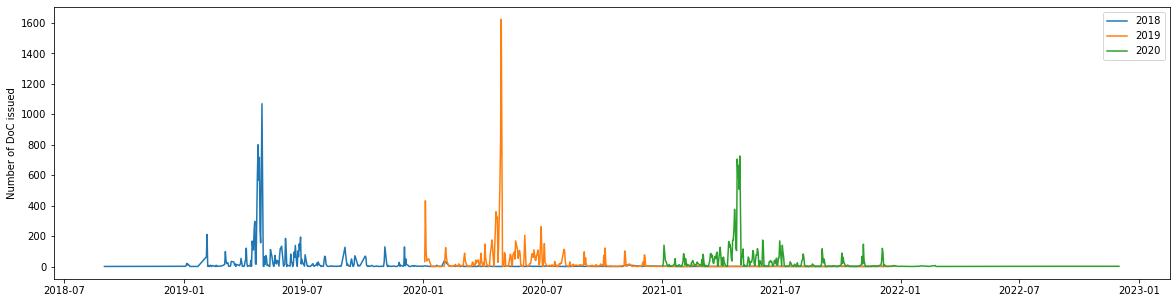

In [ ]:
dates_2018 = data_2018_full.groupby(['DoC issue date']).size().index.tolist()
count_2018 = data_2018_full.groupby(['DoC issue date']).size().tolist()

dates_2019 = data_2019_full.groupby(['DoC issue date']).size().index.tolist()
count_2019 = data_2019_full.groupby(['DoC issue date']).size().tolist()

dates_2020 = data_2020_full.groupby(['DoC issue date']).size().index.tolist()
count_2020 = data_2020_full.groupby(['DoC issue date']).size().tolist()

plt.figure(figsize = (20, 5))

plt.plot(dates_2018, count_2018, label = '2018')
plt.plot(dates_2019, count_2019, label = '2019')
plt.plot(dates_2020, count_2020, label = '2020')

plt.ylabel('Number of DoC issued')

plt.legend()

From the above plot, DoC issue date peaks around May of the year.

In [ ]:
# Might want to replace exceeding dates with peaking dates

## 2.2 Monitoring Methods

We would like to compare the different monitoring methods used over the years

In [ ]:
datasets = [data_2018_full, data_2019_full, data_2020_full]

for dataset in datasets:
    monitor = []
    for row in range(len(dataset)):
        group = ""
        if dataset.iloc[row,18] == "Yes":
            group += "A"
        if dataset.iloc[row,19] == "Yes":
            group += "B"
        if dataset.iloc[row,20] == "Yes":
            group += "C"
        if dataset.iloc[row,21] == "Yes":
            group += "D"
        if group == "":
            group = "None"
        monitor.append(group)
    dataset["Monitor"] = monitor

In [ ]:
monitor_2018 = data_2018_full.groupby("Monitor")["Monitor"].count()
monitor_2019 = data_2019_full.groupby("Monitor")["Monitor"].count()
monitor_2020 = data_2020_full.groupby("Monitor")["Monitor"].count()

In [ ]:
test = pd.DataFrame(data=monitor_2018)
test["Year"] = "2018"
test = test.rename(columns={"Monitor":"Count"}).reset_index()

test2 = pd.DataFrame(data=monitor_2019)
test2["Year"] = "2019"
test2 = test2.rename(columns={"Monitor":"Count"}).reset_index()

test3 = pd.DataFrame(data=monitor_2020)
test3["Year"] = "2020"
test3 = test3.rename(columns={"Monitor":"Count"}).reset_index()

In [ ]:
data = test.append(test2.append(test3))

In [ ]:
monitor_all = pd.DataFrame(data).reset_index().drop(columns=["index"])
monitor_all

,Monitor,Count,Year
0,A,4560,2018
1,AB,307,2018
2,ABC,124,2018
3,AC,210,2018
4,B,2320,2018
5,BC,1100,2018
6,C,2421,2018
7,None,1195,2018
8,A,5145,2019
9,AB,323,2019


In [ ]:
# drop rows with "D" as very few datapoints
monitor_all = monitor_all.drop([12,16,25])

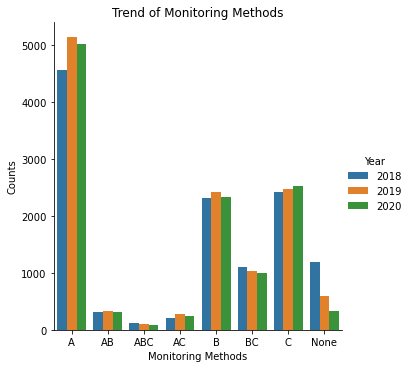

In [ ]:
sns.catplot(data = monitor_all, x = "Monitor", y = "Count",hue = "Year", kind="bar").set(
    xlabel="Monitoring Methods", ylabel = "Counts",title="Trend of Monitoring Methods")

Vessels are more likely to be monitored by monitoring method A, twice as much in 2020 compared to monitoring methods B and C.

In [ ]:
data_2018_full[data_2018_full['Monitor'] == "None"] # No monitoring method doesn't mean no records of fuel or CO2

,IMO Number,Name,Ship type,Reporting Period,Efficiency Value,Efficiency Category,Port of Registry,Home Port,Ice Class,DoC issue date,DoC expiry date,Verifier Number,Verifier Name,Verifier NAB,Verifier Address,Verifier City,Verifier Accreditation number,Verifier Country,A,B,C,D,Total fuel consumption [m tonnes],Fuel consumptions assigned to On laden [m tonnes],Total CO₂ emissions [m tonnes],CO₂ emissions from all voyages between ports under a MS jurisdiction [m tonnes],CO₂ emissions from all voyages which departed from ports under a MS jurisdiction [m tonnes],CO₂ emissions from all voyages to ports under a MS jurisdiction [m tonnes],CO₂ emissions which occurred within ports under a MS jurisdiction at berth [m tonnes],CO₂ emissions assigned to Passenger transport [m tonnes],CO₂ emissions assigned to Freight transport [m tonnes],CO₂ emissions assigned to On laden [m tonnes],Annual Total time spent at sea [hours],Annual average Fuel consumption per distance [kg / n mile],Annual average Fuel consumption per transport work (mass) [g / m tonnes · n miles],Annual average Fuel consumption per transport work (volume) [g / m³ · n miles],Annual average Fuel consumption per transport work (dwt) [g / dwt carried · n miles],Annual average Fuel consumption per transport work (pax) [g / pax · n miles],Annual average Fuel consumption per transport work (freight) [g / m tonnes · n miles],Annual average CO₂ emissions per distance [kg CO₂ / n mile],Annual average CO₂ emissions per transport work (mass) [g CO₂ / m tonnes · n miles],Annual average CO₂ emissions per transport work (volume) [g CO₂ / m³ · n miles],Annual average CO₂ emissions per transport work (dwt) [g CO₂ / dwt carried · n miles],Annual average CO₂ emissions per transport work (pax) [g CO₂ / pax · n miles],Annual average CO₂ emissions per transport work (freight) [g CO₂ / m tonnes · n miles],Through ice [n miles],Total time spent at sea [hours],Total time spent at sea through ice [hours],Fuel consumption per distance on laden voyages [kg / n mile],Fuel consumption per transport work (mass) on laden voyages [g / m tonnes · n miles],Fuel consumption per transport work (volume) on laden voyages [g / m³ · n miles],Fuel consumption per transport work (dwt) on laden voyages [g / dwt carried · n miles],Fuel consumption per transport work (pax) on laden voyages [g / pax · n miles],Fuel consumption per transport work (freight) on laden voyages [g / m tonnes · n miles],CO₂ emissions per distance on laden voyages [kg CO₂ / n mile],CO₂ emissions per transport work (mass) on laden voyages [g CO₂ / m tonnes · n miles],CO₂ emissions per transport work (volume) on laden voyages [g CO₂ / m³ · n miles],CO₂ emissions per transport work (dwt) on laden voyages [g CO₂ / dwt carried · n miles],CO₂ emissions per transport work (pax) on laden voyages [g CO₂ / pax · n miles],CO₂ emissions per transport work (freight) on laden voyages [g CO₂ / m tonnes · n miles],Monitor
7,7108930,BLACK WATCH,Passenger ship,2018.0,NaN,NaN,NaN,NaN,NaN,2019-05-14,2020-06-30,NaN,DNV GL,German national accreditation body (DAkkS),Brooktorkai 18,20457 Hamburg,D-VS-16026-01-00,Germany,NaN,NaN,NaN,NaN,8994.70,NaN,28302.42,20465.88,0.00,4953.31,2883.23,NaN,NaN,NaN,4656.00,165.28,NaN,NaN,NaN,284.60,NaN,520.05,NaN,NaN,NaN,895.52,NaN,NaN,4656.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None
20,7342469,CHL INNOVATOR,Other ship types,2018.0,NaN,NaN,Singapore,NaN,NaN,2019-03-20,2020-06-30,001,Nippon Kaiji Kyokai,Deutsche Akkredierungsstelle GmbH,"Nippon Kaiji Kyokai, 4-7, Kioi-Cho, Chiyoda-Ku...",Tokyo,VS-21325-01,Japan,NaN,NaN,NaN,NaN,3548.60,NaN,11131.25,600.38,4852.87,5340.40,337.59,NaN,NaN,NaN,3061.70,92.12,9.45,NaN,NaN,NaN,NaN,288.96,29.63,NaN,NaN,NaN,NaN,NaN,3061.70,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None
61,7814046,KRITI I,Ro-pax ship,2018.0,33.03,EIV,Chania 24,NaN,NaN,2019-04-25,2020-06-30,NaN,RINA Services Spa,ACCREDIA,Via Corsica 12,Genova,002O,Italy,NaN,NaN,NaN,NaN,15382.48,NaN,48225.24,45607.95,0.00,0.

Some ships have 0 fuel consumption or carbon emission, we want to know if these ships are not being monitored or out of service (remained at port). Since the time spent at sea for each vessel was reported voluntarily, we will look at vessels with 0 fuel consumption or carbon emission but non-zero time spent at sea.

In [ ]:
datasets = [data_2018_full, data_2019_full, data_2020_full]
not_monitored = []
grounded = []

for data in datasets:
    grounded_record = []
    not_monitored_record = []

    for i in range(len(data)):
        fuel = data.iloc[i,22]
        carbon = data.iloc[i,24]
        time = data.iloc[i,46]

        if fuel == 0 or carbon == 0:
            if time == 0:
                grounded_record.append(i)
            else:
                not_monitored_record.append(i)

    grounded.append(data.iloc[grounded_record,:])
    not_monitored.append(data.iloc[not_monitored_record,:])

In [ ]:
for i in not_monitored:
    print(len(i))

print("")

for j in grounded:
    print(len(j))

0
0
0

638
338
377


We can see that vessels with 0 fuel consumption or carbon emission are vessels with 0 time spent at sea. This vessels are most likely grounded at port.

## 2.3 Verifier Country

In [ ]:
num_countries_18 = data_2018_full.groupby('Verifier Country').size()
num_countries_18 = pd.DataFrame(num_countries_18, columns = ['Count']).reset_index()
num_countries_18['Year'] = '2018'

num_countries_19 = data_2019_full.groupby('Verifier Country').size()
num_countries_19 = pd.DataFrame(num_countries_19, columns = ['Count']).reset_index()
num_countries_19['Year'] = '2019'

num_countries_20 = data_2020_full.groupby('Verifier Country').size()
num_countries_20 = pd.DataFrame(num_countries_20, columns = ['Count']).reset_index()
num_countries_20['Year'] = '2020'

In [ ]:
data_all_years = pd.concat([num_countries_18, num_countries_19, num_countries_20], axis = 0)
data_all_years

,Verifier Country,Count,Year
0,China,302,2018
1,Croatia,16,2018
2,France,958,2018
3,Germany,2969,2018
4,Greece,2873,2018
5,India,7,2018
6,Italy,926,2018
7,Japan,1017,2018
8,"Korea, Republic of",270,2018
9,Poland,9,2018


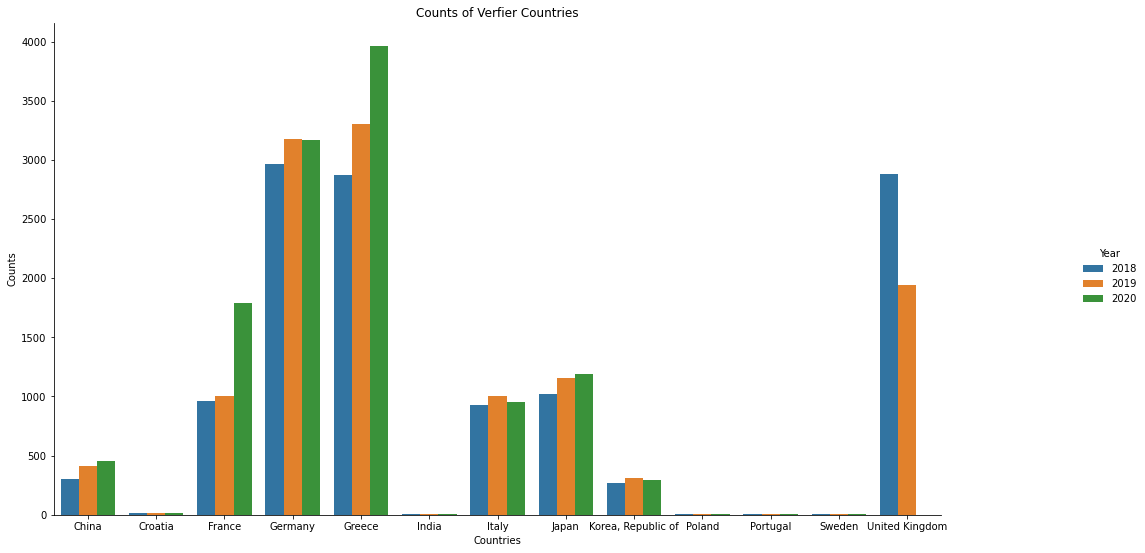

In [ ]:
plot = sns.catplot(data = data_all_years, x = "Verifier Country", y = "Count", hue = "Year", kind="bar").set(
    xlabel="Countries", ylabel = "Counts",title="Counts of Verfier Countries")
plot.fig.set_figwidth(18)
plot.fig.set_figheight(8)


Verifiers for most vessels come from Germany, Greece, France, Italy countries and Japan.

There are no verifier country with UK in 2020. Probably switch to France and Greece? If so, explains the large increase in counts for France and Germany.

## 2.4 Emission profile

In [ ]:
# Focusing only on vessels that were not grounded

data_2018_full = data_2018_full[data_2018_full['Total CO₂ emissions [m tonnes]'] != 0]
data_2019_full = data_2019_full[data_2019_full['Total CO₂ emissions [m tonnes]'] != 0]
data_2020_full = data_2020_full[data_2020_full['Total CO₂ emissions [m tonnes]'] != 0]
data_2021_full = data_2021_full[data_2021_full['Total CO₂ emissions [m tonnes]'] != 0]
data_2022_full = data_2022_full[data_2022_full['Total CO₂ emissions [m tonnes]'] != 0]

ship_types = data_2022_full['Ship type'].unique()
ship_types = np.append(ship_types, data_2021_full['Ship type'].unique())

#lookout


Text(0.5, 0.98, 'Mean of total CO₂ emissions [m tonnes], among different ship types over the years')

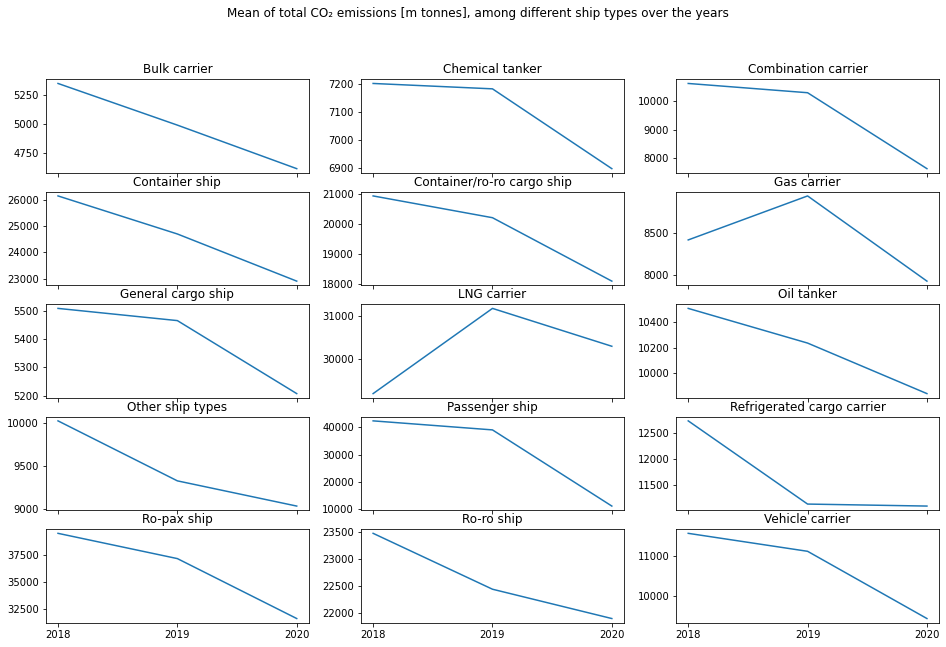

In [ ]:
ship_types = data_2018_full['Ship type'].unique()
ship_types = np.append(ship_types, data_2019_full['Ship type'].unique())
ship_types = np.append(ship_types, data_2020_full['Ship type'].unique())
ship_types = np.unique(ship_types)

#model evidence marginal likelihood with uniform prior 1/K, which gives every model prior probability, determining the MAP estimate over models amounts to picking the model that maximises the model evidence.
#remark for likelihood and marginal likelihood, there are some important differences between a likelihood and a marginal likelihood (evidence): while the likelihood is prone to overfitting, the marginal likelihood is typically not as the model parameters have been marginalized out (we no longer have to fit the parameters). Furthermore, the marginal likelihood automatically embodoies a trade-off between model complexity and data fit (Occam's razor).

@np.array

for i in range(len(ship_types)):
  stype = ship_type[i]
  stype_mean_2020 = data_2020_full[data_2020_full['Ship Types'] == stype].mean()
  stype_mean_2019 = data_2019_full[data_2019_full['Ship Types'] == stype].mean().value

  fig = plt.subplots(12, 10, figsize = (16, 10), sharex + False )
  class ship():
    def __init__(self, name, mean, tonnes, quantity):
      self.name = name
      self.mean = mean
      self.tonnes = tonnes
      self.quantity = quantity
      @n

      M = Math.log(p)
    def get_mean(self):
      def helper(x):
        #calculates the difference in the group means => stype
        s = Math.matrix(x)
        y = Math.cross(s*s)
        return y
      next = helper(self.mean)
      return self.mean

#consider the problem of comparing two probabilistic models m1, m2, we compute the posteriors p(m1|d) and p(m2|d)
#we also decided the sides of the question

@params

fig, ax = plt.subplots(6, 9, figsize = (16, 10), sharex = True)

fig, ax = plt.subplots(5, 3, figsize = (16, 10), sharex = True)


for i in range(len(ship_types)):
    stype = ship_types[i]
    stype_mean_2018 = data_2018_full[data_2018_full['Ship type'] == stype]['Total CO₂ emissions [m tonnes]'].mean()
    stype_mean_2019 = data_2019_full[data_2019_full['Ship type'] == stype]['Total CO₂ emissions [m tonnes]'].mean()
    stype_mean_2020 = data_2020_full[data_2020_full['Ship type'] == stype]['Total CO₂ emissions [m tonnes]'].mean()
    ax[i//3][i%3].plot(["2018", "2019", "2020"], [stype_mean_2018, stype_mean_2019, stype_mean_2020])
    ax[i//3][i%3].title.set_text(stype)

fig.suptitle('Mean of total CO₂ emissions [m tonnes], among different ship types over the years')

From the above plot, we can observe that the average annual CO2 emission for most ship types are experiencing a decreasing trend over the years. To get a more in depth understanding of CO2 emission with distance and transport mass for different ship types, we will take a look at the column "Annual average CO₂ emissions per transport work (mass) [g CO₂ / m tonnes · n miles]"

In [ ]:
len(data_2020_full[data_2020_full['Annual average CO₂ emissions per transport work (mass) [g CO₂ / m tonnes · n miles]'] == 0])

0

In [ ]:
print(data_2018_full.groupby('Ship type').apply(lambda x: x['Annual average CO₂ emissions per transport work (mass) [g CO₂ / m tonnes · n miles]'].isna().sum()/len(x)))
print("")
print(data_2019_full.groupby('Ship type').apply(lambda x: x['Annual average CO₂ emissions per transport work (mass) [g CO₂ / m tonnes · n miles]'].isna().sum()/len(x)))
print("")
print(data_2020_full.groupby('Ship type').apply(lambda x: x['Annual average CO₂ emissions per transport work (mass) [g CO₂ / m tonnes · n miles]'].isna().sum()/len(x)))

Ship type
Bulk carrier                  0.014706
Chemical tanker               0.004532
Combination carrier           0.000000
Container ship                0.003462
Container/ro-ro cargo ship    0.848101
Gas carrier                   0.025890
General cargo ship            0.612847
LNG carrier                   0.961905
Oil tanker                    0.008264
Other ship types              0.232759
Passenger ship                1.000000
Refrigerated cargo carrier    0.007143
Ro-pax ship                   0.952000
Ro-ro ship                    0.029412
Vehicle carrier               0.000000
dtype: float64

Ship type
Bulk carrier                  0.016604
Chemical tanker               0.004454
Combination carrier           0.000000
Container ship                0.001657
Container/ro-ro cargo ship    0.894737
Gas carrier                   0.014706
General cargo ship            0.632437
LNG carrier                   0.988327
Oil tanker                    0.009679
Other ship types            

In [ ]:
container_roro_2018 = data_2018_full[data_2018_full['Ship type'] == 'Container/ro-ro cargo ship']
print(len(container_roro_2018[(~container_roro_2018['Annual average CO₂ emissions per transport work (mass) [g CO₂ / m tonnes · n miles]'].isna())]))

container_roro_2019 = data_2019_full[data_2019_full['Ship type'] == 'Container/ro-ro cargo ship']
print(len(container_roro_2019[(~container_roro_2019['Annual average CO₂ emissions per transport work (mass) [g CO₂ / m tonnes · n miles]'].isna())]))

12
8


Create a column 'Annual average CO₂ emissions per transport work (mass/volume/pax)'

Passenger ship will follow pax for transport work

Container/ro-ro cargo ship and LNG carrier will follow volume for transport work

The remaining vessel type will follow transport work in the following order:
<br>
1) Annual average CO₂ emissions per transport work (mass) (fill with this column value first and only progress to the next one if the value for this column is not available)
<br>
2) Annual CO₂ emissions per transport work (freight) (fill with this column value first and only progress to the next one if the value for this column is not available
<br>
3) Annual CO₂ emissions per transport work (dwt)

Remove vessels without any transport work value

In [ ]:
col = 'Annual average CO₂ emissions per transport work (mass/volume/pax)'
data_2018_full['Annual average CO₂ emissions per transport work (mass/volume/pax)'] = np.nan

col_use_to_replace = 'Annual average CO₂ emissions per transport work (pax) [g CO₂ / pax · n miles]'

data_2018_full.loc[data_2018_full['Ship type'] == 'Passenger ship', col] = data_2018_full.loc[data_2018_full['Ship type'] == 'Passenger ship', col_use_to_replace]

col_use_to_replace = 'Annual average CO₂ emissions per transport work (volume) [g CO₂ / m³ · n miles]'

data_2018_full.loc[data_2018_full['Ship type'].isin(['Container/ro-ro cargo ship', 'LNG carrier']), col] = data_2018_full.loc[data_2018_full['Ship type'].isin(['Container/ro-ro cargo ship', 'LNG carrier']), col_use_to_replace]

data_2018_full = data_2018_full[~(data_2018_full['Ship type'].isin(['Passenger ship', 'Container/ro-ro cargo ship', 'LNG carrier']) & data_2018_full[col].isna())]

col_use_to_replace = 'Annual average CO₂ emissions per transport work (mass) [g CO₂ / m tonnes · n miles]'
data_2018_full.loc[:, col] = data_2018_full.loc[:, col].where(~data_2018_full.loc[:, col].isna(), (data_2018_full.loc[:, col_use_to_replace]))

col_use_to_replace = 'Annual average CO₂ emissions per transport work (freight) [g CO₂ / m tonnes · n miles]'
data_2018_full.loc[:, col] = data_2018_full.loc[:, col].where(~data_2018_full.loc[:, col].isna(), (data_2018_full.loc[:, col_use_to_replace]))

col_use_to_replace = 'Annual average CO₂ emissions per transport work (dwt) [g CO₂ / dwt carried · n miles]'
data_2018_full.loc[:, col] = data_2018_full.loc[:, col].where(~data_2018_full.loc[:, col].isna(), (data_2018_full.loc[:, col_use_to_replace]))

data_2018_full = data_2018_full[~data_2018_full[col].isna()]

In [ ]:
col = 'Annual average CO₂ emissions per transport work (mass/volume/pax)'
data_2019_full['Annual average CO₂ emissions per transport work (mass/volume/pax)'] = np.nan

col_use_to_replace = 'Annual average CO₂ emissions per transport work (pax) [g CO₂ / pax · n miles]'

data_2019_full.loc[data_2019_full['Ship type'] == 'Passenger ship', col] = data_2019_full.loc[data_2019_full['Ship type'] == 'Passenger ship', col_use_to_replace]

col_use_to_replace = 'Annual average CO₂ emissions per transport work (volume) [g CO₂ / m³ · n miles]'

data_2019_full.loc[data_2019_full['Ship type'].isin(['Container/ro-ro cargo ship', 'LNG carrier']), col] = data_2019_full.loc[data_2019_full['Ship type'].isin(['Container/ro-ro cargo ship', 'LNG carrier']), col_use_to_replace]

data_2019_full = data_2019_full[~(data_2019_full['Ship type'].isin(['Passenger ship', 'Container/ro-ro cargo ship', 'LNG carrier']) & data_2019_full[col].isna())]

col_use_to_replace = 'Annual average CO₂ emissions per transport work (mass) [g CO₂ / m tonnes · n miles]'
data_2019_full.loc[:, col] = data_2019_full.loc[:, col].where(~data_2019_full.loc[:, col].isna(), (data_2019_full.loc[:, col_use_to_replace]))

col_use_to_replace = 'Annual average CO₂ emissions per transport work (freight) [g CO₂ / m tonnes · n miles]'
data_2019_full.loc[:, col] = data_2019_full.loc[:, col].where(~data_2019_full.loc[:, col].isna(), (data_2019_full.loc[:, col_use_to_replace]))

col_use_to_replace = 'Annual average CO₂ emissions per transport work (dwt) [g CO₂ / dwt carried · n miles]'
data_2019_full.loc[:, col] = data_2019_full.loc[:, col].where(~data_2019_full.loc[:, col].isna(), (data_2019_full.loc[:, col_use_to_replace]))

data_2019_full = data_2019_full[~data_2019_full[col].isna()]

In [ ]:
col = 'Annual average CO₂ emissions per transport work (mass/volume/pax)'
data_2020_full['Annual average CO₂ emissions per transport work (mass/volume/pax)'] = np.nan

col_use_to_replace = 'Annual average CO₂ emissions per transport work (pax) [g CO₂ / pax · n miles]'

data_2020_full.loc[data_2020_full['Ship type'] == 'Passenger ship', col] = data_2020_full.loc[data_2020_full['Ship type'] == 'Passenger ship', col_use_to_replace]

col_use_to_replace = 'Annual average CO₂ emissions per transport work (volume) [g CO₂ / m³ · n miles]'

data_2020_full.loc[data_2020_full['Ship type'].isin(['Container/ro-ro cargo ship', 'LNG carrier']), col] = data_2020_full.loc[data_2020_full['Ship type'].isin(['Container/ro-ro cargo ship', 'LNG carrier']), col_use_to_replace]

data_2020_full = data_2020_full[~(data_2020_full['Ship type'].isin(['Passenger ship', 'Container/ro-ro cargo ship', 'LNG carrier']) & data_2019_full[col].isna())]

col_use_to_replace = 'Annual average CO₂ emissions per transport work (mass) [g CO₂ / m tonnes · n miles]'
data_2020_full.loc[:, col] = data_2020_full.loc[:, col].where(~data_2020_full.loc[:, col].isna(), (data_2020_full.loc[:, col_use_to_replace]))

col_use_to_replace = 'Annual average CO₂ emissions per transport work (freight) [g CO₂ / m tonnes · n miles]'
data_2020_full.loc[:, col] = data_2020_full.loc[:, col].where(~data_2020_full.loc[:, col].isna(), (data_2020_full.loc[:, col_use_to_replace]))

col_use_to_replace = 'Annual average CO₂ emissions per transport work (dwt) [g CO₂ / dwt carried · n miles]'
data_2020_full.loc[:, col] = data_2020_full.loc[:, col].where(~data_2020_full.loc[:, col].isna(), (data_2020_full.loc[:, col_use_to_replace]))

data_2020_full = data_2020_full[~data_2020_full[col].isna()]

In [ ]:
print(data_2018_full.groupby('Ship type').apply(lambda x: x['Annual average CO₂ emissions per transport work (mass/volume/pax)'].isna().sum()/len(x)))
print("")
print(data_2019_full.groupby('Ship type').apply(lambda x: x['Annual average CO₂ emissions per transport work (mass/volume/pax)'].isna().sum()/len(x)))
print("")
print(data_2020_full.groupby('Ship type').apply(lambda x: x['Annual average CO₂ emissions per transport work (mass/volume/pax)'].isna().sum()/len(x)))

Ship type
Bulk carrier                  0.0
Chemical tanker               0.0
Combination carrier           0.0
Container ship                0.0
Container/ro-ro cargo ship    0.0
Gas carrier                   0.0
General cargo ship            0.0
LNG carrier                   0.0
Oil tanker                    0.0
Other ship types              0.0
Passenger ship                0.0
Refrigerated cargo carrier    0.0
Ro-pax ship                   0.0
Ro-ro ship                    0.0
Vehicle carrier               0.0
dtype: float64

Ship type
Bulk carrier                  0.0
Chemical tanker               0.0
Combination carrier           0.0
Container ship                0.0
Container/ro-ro cargo ship    0.0
Gas carrier                   0.0
General cargo ship            0.0
LNG carrier                   0.0
Oil tanker                    0.0
Other ship types              0.0
Passenger ship                0.0
Refrigerated cargo carrier    0.0
Ro-pax ship                   0.0
Ro-ro ship  

Text(0.5, 0.98, 'Median of annual average fuel consumption per transport work (mass/volume/pax), among different ship types over the years')

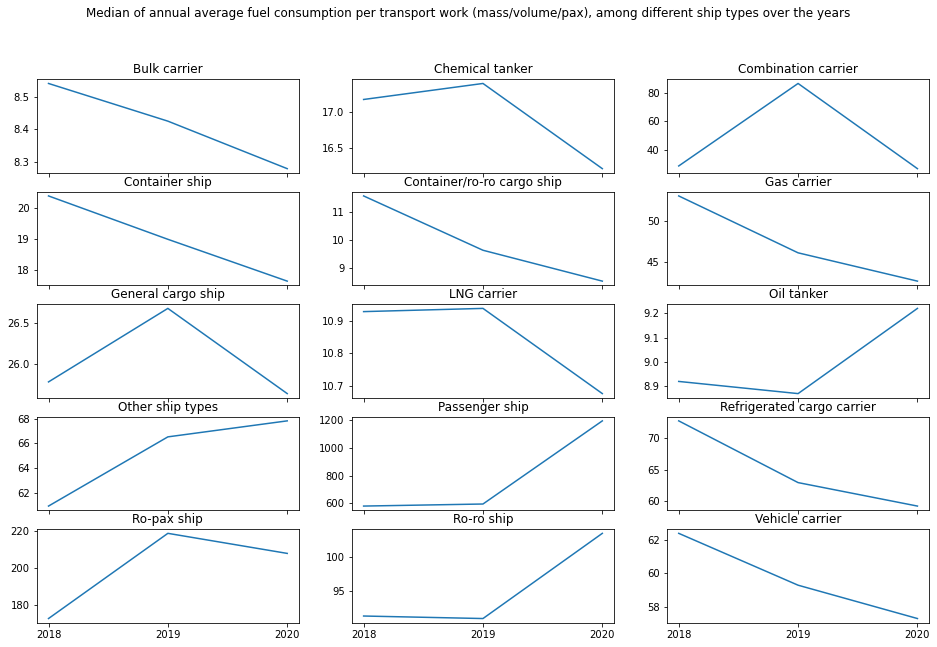

In [ ]:
fig, ax = plt.subplots(5, 3, figsize = (16, 10), sharex = True)

for i in range(len(ship_types)):
    stype = ship_types[i]
    stype_median_2018 = data_2018_full[data_2018_full['Ship type'] == stype]['Annual average CO₂ emissions per transport work (mass/volume/pax)'].median()
    stype_median_2019 = data_2019_full[data_2019_full['Ship type'] == stype]['Annual average CO₂ emissions per transport work (mass/volume/pax)'].median()
    stype_median_2020 = data_2020_full[data_2020_full['Ship type'] == stype]['Annual average CO₂ emissions per transport work (mass/volume/pax)'].median()
    ax[i//3][i%3].plot(["2018", "2019", "2020"], [stype_median_2018, stype_median_2019, stype_median_2020])
    ax[i//3][i%3].title.set_text(stype)

fig.suptitle('Median of annual average fuel consumption per transport work (mass/volume/pax), among different ship types over the years')

Median value was used to provide a simple measure of the baseline CO2 emission of different ship types. From the above plot, not all ships are experiencing a downward trend.

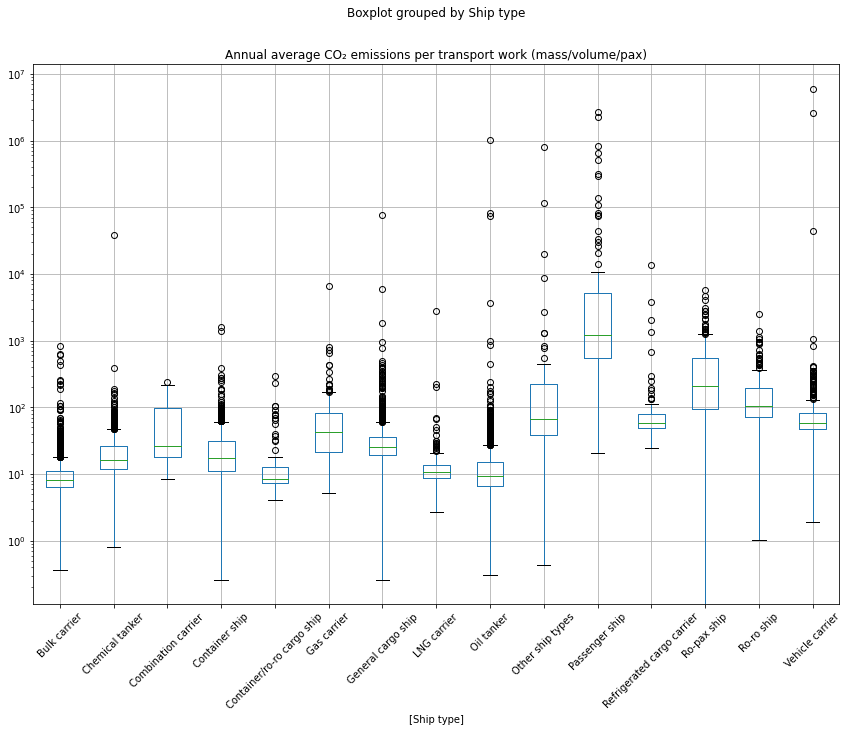

In [ ]:
data_2020_full[['Ship type', 'Annual average CO₂ emissions per transport work (mass/volume/pax)']].boxplot(by = 'Ship type', figsize = (14, 10))

plt.xticks(rotation = 45)
plt.yscale('log')

Boxplot shows that the emission value for most ships in year 2020 are right skewed.

In [ ]:
data_2020_full[['Ship type', 'Annual average CO₂ emissions per transport work (mass/volume/pax)']].groupby(['Ship type']).describe()
#data_2020_full['Ship type', 'Annual average emissions per transport work (mass/volume/pax)']].groupby(['Ship type']).describe()

Annual average CO₂ emissions per transport work (mass/volume/pax)  \
                                                                                       count   
Ship type                                                                                      
Bulk carrier                                                           3066.0                  
Chemical tanker                                                        1326.0                  
Combination carrier                                                      15.0                  
Container ship                                                         1816.0                  
Container/ro-ro cargo ship                                               70.0                  
Gas carrier                                                             339.0                  
General cargo ship                                                     1208.0                  
LNG carrier                                                             260.0                  
Oil tanker                                                             1835.0                  
Other ship types                                                        122.0                  
Passenger ship                                                          101.0                  
Refrigerated cargo carrier                                              144.0                  
Ro-pax ship                                                             382.0                  
Ro-ro ship                                                              238.0                  
Vehicle carrier                                                         451.0                  

                                                                          \
                                    mean            std    min       25%   
Ship type                                                                  
Bulk carrier                   11.169312      27.043826   0.37    6.4425   
Chemical tanker                50.985339    1040.614046   0.80   11.9175   
Combination carrier            69.684000      79.673524   8.36   17.7450   
Container ship                 26.974180      55.422283   0.26   11.0875   
Container/ro-ro cargo ship     26.453857      48.195408   4.05    7.3425   
Gas carrier                    86.457434     365.403973   5.26   21.4550   
General cargo ship            106.483228    2199.123059   0.26   19.1600   
LNG carrier                    24.512538     172.048424   2.73    8.6275   
Oil tanker                    659.471586   24035.924740   0.31    6.6200   
Other ship types             7943.357459   73356.899268   0.43   39.0050   
Passenger ship              81869.648713  359584.304026  20.45  548.8100   
Refrigerated cargo carrier    213.768750    1171.373074  24.34   48.5450   
Ro-pax ship                   432.743743     616.221418   0.00   92.9075   
Ro-ro ship                    183.773193     245.424064   1.03   71.7800   
Vehicle carrier             19172.113925  305537.103296   1.91   46.7200   

                                                             
                                 50%        75%         max  
Ship type                                                    
Bulk carrier                   8.280    11.0100      834.47  
Chemical tanker               16.220    26.1475    37908.28  
Combination carrier           26.560    96.5600      237.89  
Container ship                17.630    31.2025     1628.95  
Container/ro-ro cargo ship     8.545    12.9300      291.71  
Gas carrier                   42.660    81.1400     6614.10  
General cargo ship            25.650    35.7125    76207.30  
LNG carrier                   10.675    13.7175     2770.49  
Oil tanker                     9.220    14.9500  1023891.80  
Other ship types              67.810   222.8150   802805.71  
Passenger ship              1195.630  5203.7200  2638628.99  
Refrigerated cargo carrier    59.260    79.2800    13448.63  

The above table gives a rough idea of the distribution of annual average CO₂ emissions per transport work (mass/volume/pax) for different ship types. When comparing 75th percentile with 50th percentile, for some ship types such as Passenger ship, CO2 emission value is a few times lower for the median value. This suggest that using median annual average CO2 emission per transport work as a baseline for comparison for ship types can significantly reduce CO2 emission if vessel owner are motivated to achieve the baseline value.

The table also shows that the emission annual average CO2 emission per transport work as a baseline for comparison for ship types can significantly reduce CO2 emission if vessel owners can all strive to keep CO2 emissions below baseline value.

Text(0.5, 0.98, 'Annual average CO₂ emissions per transport work (mass/volume/pax) against Efficiency Value for each ship type')

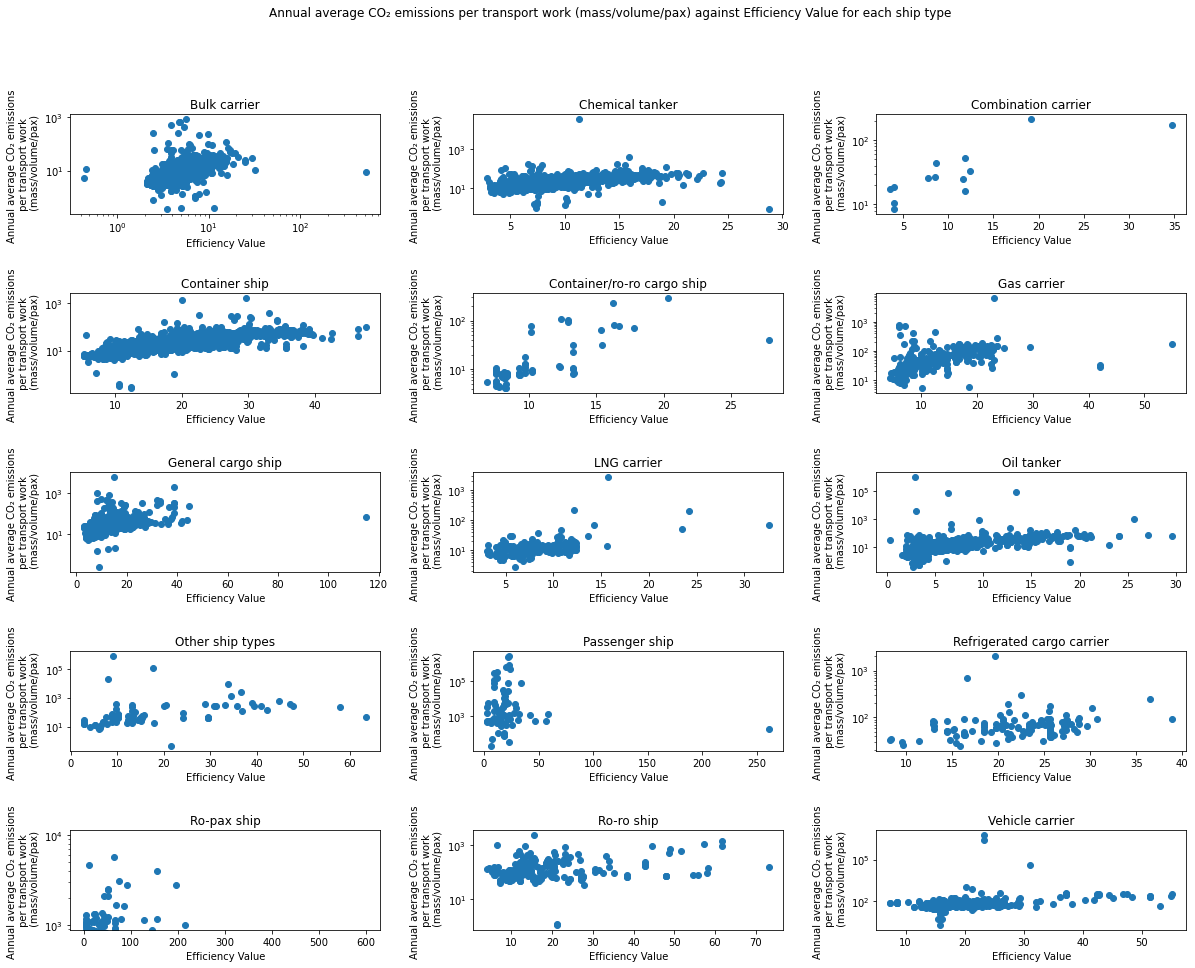

In [ ]:
ship_x = ['Bulk carrier']
fig, ax = plt.subplots(5, 3, figsize = (20, 15))
plt.subplots_adjust(hspace = 0.8)
plt.subplots_adjust(wspace = 0.3)

for i in range(len(ship_types)):
    stype = ship_types[i]
    ship_type_df_2020 = data_2020_full[data_2020_full['Ship type'] == stype]
    x = ship_type_df_2020['Efficiency Value'].values
    y = ship_type_df_2020['Annual average CO₂ emissions per transport work (mass/volume/pax)'].values
    ax[i//3][i%3].scatter(x, y)
    ax[i//3][i%3].title.set_text(stype)
    ax[i//3][i%3].set_yscale('log')
    ax[i//3][i%3].set_ylabel('Annual average CO₂ emissions \n per transport work \n (mass/volume/pax)', fontsize = 10)
    ax[i//3][i%3].set_xlabel('Efficiency Value')
    ax[i//3][i%3].set_xscale('ln')
    if stype in ship_x:
        ax[i//3][i%3].set_xscale('log')

fig.suptitle('Annual average CO₂ emissions per transport work (mass/volume/pax) against Efficiency Value for each ship type')

In [ ]:
# Can the above plot be used for detecting outlier. Is it true that efficency value
# is directly proportional to annual aevrage CO2 emission per workload or there
# is a different interpretation for efficency value?

# 3. Modelling

In [ ]:
lst_2018 = []
lst_2019 = []
lst_2020 = []

for i in range(len(ship_types)):
    stype = ship_types[i]
    stype_2018 = data_2018_full[data_2018_full['Ship type'] == stype]
    q1, q3 = stype_2018['Annual average CO₂ emissions per transport work (mass/volume/pax)'].quantile(0.25), stype_2018['Annual average CO₂ emissions per transport work (mass/volume/pax)'].quantile(0.75)
    iqr = q3 - q1
    stype_2018 = stype_2018[stype_2018['Annual average CO₂ emissions per transport work (mass/volume/pax)'] >= (q1 - (1.5 * iqr))]
    stype_2018 = stype_2018[stype_2018['Annual average CO₂ emissions per transport work (mass/volume/pax)'] <= (q3 + (1.5 * iqr))]
    lst_2018.append(stype_2018)

    stype_2019 = data_2019_full[data_2019_full['Ship type'] == stype]
    q1, q3 = stype_2019['Annual average CO₂ emissions per transport work (mass/volume/pax)'].quantile(0.25), stype_2019['Annual average CO₂ emissions per transport work (mass/volume/pax)'].quantile(0.75)
    iqr = q3 - q1
    stype_2019 = stype_2019[stype_2019['Annual average CO₂ emissions per transport work (mass/volume/pax)'] >= (q1 - (1.5 * iqr))]
    stype_2019 = stype_2019[stype_2019['Annual average CO₂ emissions per transport work (mass/volume/pax)'] <= (q3 + (1.5 * iqr))]
    lst_2019.append(stype_2019)

    stype_2020 = data_2020_full[data_2020_full['Ship type'] == stype]
    q1, q3 = stype_2020['Annual average CO₂ emissions per transport work (mass/volume/pax)'].quantile(0.25), stype_2020['Annual average CO₂ emissions per transport work (mass/volume/pax)'].quantile(0.75)
    iqr = q3 - q1
    stype_2020 = stype_2020[stype_2020['Annual average CO₂ emissions per transport work (mass/volume/pax)'] >= (q1 - (1.5 * iqr))]
    stype_2020 = stype_2020[stype_2020['Annual average CO₂ emissions per transport work (mass/volume/pax)'] <= (q3 + (1.5 * iqr))]
    lst_2020.append(stype_2020)

In [ ]:
data_2018_full = pd.concat(lst_2018, axis = 0)
data_2019_full = pd.concat(lst_2019, axis = 0)
data_2029_full = pd.concat(lst_2020, axis = 0)

print(data_2018_full.shape)
print(data_2019_full.shape)
print(data_2020_full.shape)

(10505, 62)
(10956, 62)
(11373, 62)


In [ ]:
col_to_focus_2020 = data_2020_full.columns[~(data_2020_full.isna().sum() > int(len(data_2020_full) * 0.7))]

col_to_focus_2020

Index(['IMO Number', 'Name', 'Ship type', 'Reporting Period',
       'Efficiency Value', 'Efficiency Category', 'Port of Registry',
       'DoC issue date', 'DoC expiry date', 'Verifier Number', 'Verifier Name',
       'Verifier NAB', 'Verifier Address', 'Verifier City',
       'Verifier Accreditation number', 'Verifier Country', 'A', 'B', 'C',
       'Total fuel consumption [m tonnes]', 'Total CO₂ emissions [m tonnes]',
       'CO₂ emissions from all voyages between ports under a MS jurisdiction [m tonnes]',
       'CO₂ emissions from all voyages which departed from ports under a MS jurisdiction [m tonnes]',
       'CO₂ emissions from all voyages to ports under a MS jurisdiction [m tonnes]',
       'CO₂ emissions which occurred within ports under a MS jurisdiction at berth [m tonnes]',
       'Annual Total time spent at sea [hours]',
       'Annual average Fuel consumption per distance [kg / n mile]',
       'Annual average Fuel consumption per transport work (mass) [g / m tonnes · n 

In [ ]:
col_to_focus_2020 = col_to_focus_2020.drop(['Name', 'Reporting Period', 'DoC expiry date',
                                            'Verifier Number', 'Verifier Name', 'Verifier NAB', 'Verifier Address',
                                            'Verifier City', 'Verifier Accreditation number',
                                            'Annual average CO₂ emissions per transport work (mass) [g CO₂ / m tonnes · n miles]',
                                            'CO₂ emissions from all voyages between ports under a MS jurisdiction [m tonnes]',
                                            'CO₂ emissions from all voyages which departed from ports under a MS jurisdiction [m tonnes]',
                                            'CO₂ emissions from all voyages to ports under a MS jurisdiction [m tonnes]',
                                            'CO₂ emissions which occurred within ports under a MS jurisdiction at berth [m tonnes]',
                                            'Annual Total time spent at sea [hours]',
                                            'Annual average Fuel consumption per distance [kg / n mile]',
                                            'Annual average Fuel consumption per transport work (mass) [g / m tonnes · n miles]',
                                            'Annual average CO₂ emissions per distance [kg CO₂ / n mile]',
                                            'Annual average CO₂ emissions per transport work (mass) [g CO₂ / m tonnes · n miles]',
                                            'Total time spent at sea [hours]', 'DoC issue date', 'Monitor',
                                            'Annual average CO₂ emissions per transport work (mass) [g CO₂ / m tonnes · n miles]',
                                            'Total fuel consumption [m tonnes]', 'Total CO₂ emissions [m tonnes]'])

col_to_focus_2020

Index(['IMO Number', 'Ship type', 'Efficiency Value', 'Efficiency Category',
       'Port of Registry', 'Verifier Country', 'A', 'B', 'C',
       'Annual average CO₂ emissions per transport work (mass/volume/pax)'],
      dtype='object')

In [ ]:
col_to_focus_2019 = data_2019_full.columns[~(data_2019_full.isna().sum() > int(len(data_2019_full) * 0.7))]

col_to_focus_2019

Index(['IMO Number', 'Name', 'Ship type', 'Reporting Period',
       'Efficiency Value', 'Efficiency Category', 'Port of Registry',
       'DoC issue date', 'DoC expiry date', 'Verifier Number', 'Verifier Name',
       'Verifier NAB', 'Verifier Address', 'Verifier City',
       'Verifier Accreditation number', 'Verifier Country', 'A', 'B', 'C',
       'Total fuel consumption [m tonnes]', 'Total CO₂ emissions [m tonnes]',
       'CO₂ emissions from all voyages between ports under a MS jurisdiction [m tonnes]',
       'CO₂ emissions from all voyages which departed from ports under a MS jurisdiction [m tonnes]',
       'CO₂ emissions from all voyages to ports under a MS jurisdiction [m tonnes]',
       'CO₂ emissions which occurred within ports under a MS jurisdiction at berth [m tonnes]',
       'Annual Total time spent at sea [hours]',
       'Annual average Fuel consumption per distance [kg / n mile]',
       'Annual average Fuel consumption per transport work (mass) [g / m tonnes · n 

In [ ]:
col_to_focus_2019 = col_to_focus_2019.drop(['Name', 'Ship type', 'Verifier Number', 'Reporting Period', 'Verifier Name', 'Verifier NAB', 'Verifier Address',
                                            'Verifier City', 'Verifier Accreditation number', 'DoC expiry date', 'DoC issue date', 'Monitor',
                                            'Annual average CO₂ emissions per transport work (mass) [g CO₂ / m tonnes · n miles]', 'A', 'B', 'C'])

col_to_focus_2019

Index(['IMO Number', 'Efficiency Value', 'Efficiency Category',
       'Port of Registry', 'Verifier Country',
       'Total fuel consumption [m tonnes]', 'Total CO₂ emissions [m tonnes]',
       'CO₂ emissions from all voyages between ports under a MS jurisdiction [m tonnes]',
       'CO₂ emissions from all voyages which departed from ports under a MS jurisdiction [m tonnes]',
       'CO₂ emissions from all voyages to ports under a MS jurisdiction [m tonnes]',
       'CO₂ emissions which occurred within ports under a MS jurisdiction at berth [m tonnes]',
       'Annual Total time spent at sea [hours]',
       'Annual average Fuel consumption per distance [kg / n mile]',
       'Annual average Fuel consumption per transport work (mass) [g / m tonnes · n miles]',
       'Annual average CO₂ emissions per distance [kg CO₂ / n mile]',
       'Total time spent at sea [hours]',
       'Annual average CO₂ emissions per transport work (mass/volume/pax)'],
      dtype='object')

In [ ]:
col_to_focus_2018 = data_2018_full.columns[~(data_2018_full.isna().sum() > int(len(data_2018_full) * 0.7))]

col_to_focus_2018

Index(['IMO Number', 'Name', 'Ship type', 'Reporting Period',
       'Efficiency Value', 'Efficiency Category', 'Port of Registry',
       'DoC issue date', 'DoC expiry date', 'Verifier Number', 'Verifier Name',
       'Verifier NAB', 'Verifier Address', 'Verifier City',
       'Verifier Accreditation number', 'Verifier Country', 'A', 'B', 'C',
       'Total fuel consumption [m tonnes]', 'Total CO₂ emissions [m tonnes]',
       'CO₂ emissions from all voyages between ports under a MS jurisdiction [m tonnes]',
       'CO₂ emissions from all voyages which departed from ports under a MS jurisdiction [m tonnes]',
       'CO₂ emissions from all voyages to ports under a MS jurisdiction [m tonnes]',
       'CO₂ emissions which occurred within ports under a MS jurisdiction at berth [m tonnes]',
       'Annual Total time spent at sea [hours]',
       'Annual average Fuel consumption per distance [kg / n mile]',
       'Annual average Fuel consumption per transport work (mass) [g / m tonnes · n 

In [ ]:
col_to_focus_2018 = col_to_focus_2018.drop(['Name', 'Ship type', 'Reporting Period', 'Verifier Number', 'Verifier Name', 'Verifier NAB', 'Verifier Address',
                                            'Verifier City', 'Verifier Accreditation number', 'DoC expiry date', 'DoC issue date', 'Monitor',
                                            'Annual average CO₂ emissions per transport work (mass) [g CO₂ / m tonnes · n miles]', 'A', 'B', 'C'])

col_to_focus_2018

Index(['IMO Number', 'Efficiency Value', 'Efficiency Category',
       'Port of Registry', 'Verifier Country',
       'Total fuel consumption [m tonnes]', 'Total CO₂ emissions [m tonnes]',
       'CO₂ emissions from all voyages between ports under a MS jurisdiction [m tonnes]',
       'CO₂ emissions from all voyages which departed from ports under a MS jurisdiction [m tonnes]',
       'CO₂ emissions from all voyages to ports under a MS jurisdiction [m tonnes]',
       'CO₂ emissions which occurred within ports under a MS jurisdiction at berth [m tonnes]',
       'Annual Total time spent at sea [hours]',
       'Annual average Fuel consumption per distance [kg / n mile]',
       'Annual average Fuel consumption per transport work (mass) [g / m tonnes · n miles]',
       'Annual average CO₂ emissions per distance [kg CO₂ / n mile]',
       'Total time spent at sea [hours]',
       'Annual average CO₂ emissions per transport work (mass/volume/pax)'],
      dtype='object')

In [ ]:
data_col_use_2020 = data_2020_full[col_to_focus_2020]

data_col_use_2019 = data_2019_full[col_to_focus_2019]

data_col_use_2018 = data_2018_full[col_to_focus_2019]

In [ ]:
def col_name_year(x, year):
    if x != 'IMO Number':
        return x + year
    else:
        return x

data_col_use_2019.columns = list(map(lambda x: col_name_year(x, "_2019"), col_to_focus_2019.tolist()))

data_col_use_2018.columns = list(map(lambda x: col_name_year(x, "_2018"), col_to_focus_2019.tolist()))

In [ ]:
cat_features = ['Ship type', 'Efficiency Category', 'Port of Registry', 'Verifier Country', 'A', 'B', 'C']

cat_dict = {}

for cat in cat_features:
    code, level = pd.factorize(data_col_use_2020[cat])
    data_col_use_2020[cat] = code
    cat_dict[cat] = level

In [ ]:
cat_features = ['Efficiency Category_2019', 'Port of Registry_2019', 'Verifier Country_2019']

cat_dict = {}

for cat in cat_features:
    code, level = pd.factorize(data_col_use_2019[cat])
    data_col_use_2019[cat] = code
    cat_dict[cat] = level


cat_features = ['Efficiency Category_2018', 'Port of Registry_2018', 'Verifier Country_2018']

cat_dict = {}

for cat in cat_features:
    code, level = pd.factorize(data_col_use_2018[cat])
    data_col_use_2018[cat] = code
    cat_dict[cat] = level

In [ ]:
full_data = data_col_use_2020.merge(data_col_use_2019, on = ['IMO Number'], how = 'left', suffixes = None)
full_data = full_data.merge(data_col_use_2018, on = ['IMO Number'], how = 'left', suffixes = None)

In [ ]:
full_data = full_data.iloc[:, 1:]

In [ ]:
full_data.columns = full_data.columns.str.replace('[', '(').str.replace(']', ')')

In [ ]:
features = full_data.iloc[:, ~(full_data.columns == 'Annual average CO₂ emissions per transport work (mass/volume/pax)')]

target = full_data['Annual average CO₂ emissions per transport work (mass/volume/pax)'].values

In [ ]:
features

,Ship type,Efficiency Value,Efficiency Category,Port of Registry,Verifier Country,A,B,C,Efficiency Value_2019,Efficiency Category_2019,Port of Registry_2019,Verifier Country_2019,Total fuel consumption (m tonnes)_2019,Total CO₂ emissions (m tonnes)_2019,CO₂ emissions from all voyages between ports under a MS jurisdiction (m tonnes)_2019,CO₂ emissions from all voyages which departed from ports under a MS jurisdiction (m tonnes)_2019,CO₂ emissions from all voyages to ports under a MS jurisdiction (m tonnes)_2019,CO₂ emissions which occurred within ports under a MS jurisdiction at berth (m tonnes)_2019,Annual Total time spent at sea (hours)_2019,Annual average Fuel consumption per distance (kg / n mile)_2019,Annual average Fuel consumption per transport work (mass) (g / m tonnes · n miles)_2019,Annual average CO₂ emissions per distance (kg CO₂ / n mile)_2019,Total time spent at sea (hours)_2019,Annual average CO₂ emissions per transport work (mass/volume/pax)_2019,Efficiency Value_2018,Efficiency Category_2018,Port of Registry_2018,Verifier Country_2018,Total fuel consumption (m tonnes)_2018,Total CO₂ emissions (m tonnes)_2018,CO₂ emissions from all voyages between ports under a MS jurisdiction (m tonnes)_2018,CO₂ emissions from all voyages which departed from ports under a MS jurisdiction (m tonnes)_2018,CO₂ emissions from all voyages to ports under a MS jurisdiction (m tonnes)_2018,CO₂ emissions which occurred within ports under a MS jurisdiction at berth (m tonnes)_2018,Annual Total time spent at sea (hours)_2018,Annual average Fuel consumption per distance (kg / n mile)_2018,Annual average Fuel consumption per transport work (mass) (g / m tonnes · n miles)_2018,Annual average CO₂ emissions per distance (kg CO₂ / n mile)_2018,Total time spent at sea (hours)_2018,Annual average CO₂ emissions per transport work (mass/volume/pax)_2018
0,0,31.73,0,0,0,0,-1,-1,31.73,0.0,60.0,1.0,5187.27,16398.94,11526.87,1145.32,1614.42,2112.33,3687.78,115.79,NaN,366.04,3687.78,1047.05,31.73,0.0,55.0,3.0,6151.40,19478.27,14233.60,982.50,1374.10,2887.16,4286.21,120.93,NaN,382.91,4286.21,1124.27
1,1,57.84,0,1,1,0,-1,-1,57.84,0.0,23.0,2.0,1607.60,5059.00,0.00,2394.63,2509.12,155.25,2743.00,56.58,105.98,178.06,2743.00,333.51,NaN,-1.0,16.0,2.0,549.00,1724.63,0.00,938.13,753.25,33.25,1008.00,63.46,91.14,199.36,1008.00,286.30
2,2,19.40,0,-1,0,0,-1,-1,19.40,0.0,-1.0,5.0,3468.00,11118.41,9871.00,0.00,0.00,1335.90,2224.00,108.42,NaN,347.58,2224.00,395.67,146.00,0.0,-1.0,1.0,5225.00,16751.35,14623.63,0.00,0.00,2127.72,3753.82,104.94,NaN,336.43,3753.82,206.78
3,3,48.71,0,2,0,0,-1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2,9.29,0,3,0,0,-1,-1,9.29,0.0,381.0,5.0,4122.60,13046.64,10956.03,0.00,0.00,2053.17,3825.50,83.87,NaN,265.41,3825.50,134.36,9.29,0.0,353.0,0.0,4079.71,12912.35,12243.30,0.00,0.00,669.00,3787.00,83.73,NaN,265.00,3787.00,172.77
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11368,5,14.47,1,-1,0,-1,0,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11369,5,14.12,1,-1,0,-1,0,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11370,5,14.21,1,-1,0,-1,0,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11371,5,14.17,1,-1,0,-1,0,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
train_features, valid_features, train_target, valid_target = train_test_split(features, target, test_size = 0.2, random_state = 0)

In [ ]:
model = lgbm.LGBMRegressor(n_estimator = 1000, random_state = 10, early_stopping = 3)
xc
model.fit(train_features, train_target, eval_set = [(valid_features, valid_target)], verbose = 1)

[LightGBM] [Warning] Unknown parameter: n_estimator
[LightGBM] [Warning] early_stopping_round is set=3, early_stopping=3 will be ignored. Current value: early_stopping_round=3
[1]	valid_0's l2: 3.37893e+08
Training until validation scores don't improve for 3 rounds
[2]	valid_0's l2: 3.31799e+08
[3]	valid_0's l2: 3.32214e+08
[4]	valid_0's l2: 3.37773e+08
[5]	valid_0's l2: 3.4004e+08
Early stopping, best iteration is:
[2]	valid_0's l2: 3.31799e+08


LGBMRegressor(early_stopping=3, n_estimator=1000, random_state=10)

In [ ]:
np.sum(np.square(model.predict(valid_features) - valid_target))
#calculale the square of feature error

754842703396.2692

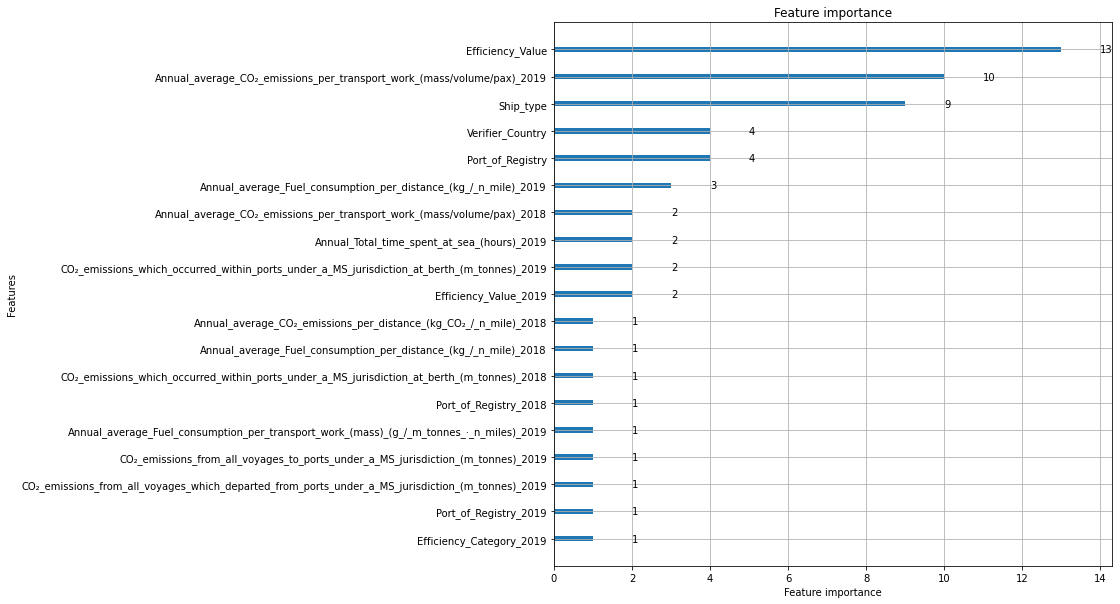

In [ ]:
lgbm.plot_importance(model, figsize = (10, 10))

In [ ]:
full_data

,Ship type,Efficiency Value,Efficiency Category,Port of Registry,Verifier Country,A,B,C,Annual average CO₂ emissions per transport work (mass/volume/pax),Efficiency Value_2019,Efficiency Category_2019,Port of Registry_2019,Verifier Country_2019,Total fuel consumption (m tonnes)_2019,Total CO₂ emissions (m tonnes)_2019,CO₂ emissions from all voyages between ports under a MS jurisdiction (m tonnes)_2019,CO₂ emissions from all voyages which departed from ports under a MS jurisdiction (m tonnes)_2019,CO₂ emissions from all voyages to ports under a MS jurisdiction (m tonnes)_2019,CO₂ emissions which occurred within ports under a MS jurisdiction at berth (m tonnes)_2019,Annual Total time spent at sea (hours)_2019,Annual average Fuel consumption per distance (kg / n mile)_2019,Annual average Fuel consumption per transport work (mass) (g / m tonnes · n miles)_2019,Annual average CO₂ emissions per distance (kg CO₂ / n mile)_2019,Total time spent at sea (hours)_2019,Annual average CO₂ emissions per transport work (mass/volume/pax)_2019,Efficiency Value_2018,Efficiency Category_2018,Port of Registry_2018,Verifier Country_2018,Total fuel consumption (m tonnes)_2018,Total CO₂ emissions (m tonnes)_2018,CO₂ emissions from all voyages between ports under a MS jurisdiction (m tonnes)_2018,CO₂ emissions from all voyages which departed from ports under a MS jurisdiction (m tonnes)_2018,CO₂ emissions from all voyages to ports under a MS jurisdiction (m tonnes)_2018,CO₂ emissions which occurred within ports under a MS jurisdiction at berth (m tonnes)_2018,Annual Total time spent at sea (hours)_2018,Annual average Fuel consumption per distance (kg / n mile)_2018,Annual average Fuel consumption per transport work (mass) (g / m tonnes · n miles)_2018,Annual average CO₂ emissions per distance (kg CO₂ / n mile)_2018,Total time spent at sea (hours)_2018,Annual average CO₂ emissions per transport work (mass/volume/pax)_2018
0,0,31.73,0,0,0,0,-1,-1,1407.97,31.73,0.0,60.0,1.0,5187.27,16398.94,11526.87,1145.32,1614.42,2112.33,3687.78,115.79,NaN,366.04,3687.78,1047.05,31.73,0.0,55.0,3.0,6151.40,19478.27,14233.60,982.50,1374.10,2887.16,4286.21,120.93,NaN,382.91,4286.21,1124.27
1,1,57.84,0,1,1,0,-1,-1,211.88,57.84,0.0,23.0,2.0,1607.60,5059.00,0.00,2394.63,2509.12,155.25,2743.00,56.58,105.98,178.06,2743.00,333.51,NaN,-1.0,16.0,2.0,549.00,1724.63,0.00,938.13,753.25,33.25,1008.00,63.46,91.14,199.36,1008.00,286.30
2,2,19.40,0,-1,0,0,-1,-1,13.85,19.40,0.0,-1.0,5.0,3468.00,11118.41,9871.00,0.00,0.00,1335.90,2224.00,108.42,NaN,347.58,2224.00,395.67,146.00,0.0,-1.0,1.0,5225.00,16751.35,14623.63,0.00,0.00,2127.72,3753.82,104.94,NaN,336.43,3753.82,206.78
3,3,48.71,0,2,0,0,-1,0,540.98,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2,9.29,0,3,0,0,-1,-1,143.45,9.29,0.0,381.0,5.0,4122.60,13046.64,10956.03,0.00,0.00,2053.17,3825.50,83.87,NaN,265.41,3825.50,134.36,9.29,0.0,353.0,0.0,4079.71,12912.35,12243.30,0.00,0.00,669.00,3787.00,83.73,NaN,265.00,3787.00,172.77
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11368,5,14.47,1,-1,0,-1,0,-1,27.11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11369,5,14.12,1,-1,0,-1,0,-1,53.83,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11370,5,14.21,1,-1,0,-1,0,-1,39.68,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11371,5,14.17,1,-1,0,-1,0,-1,43.28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# actual_emission = pd.DataFrame(valid_target).reset_index()
# actual_emission = actual_emission.rename(columns={"index":"Original Index"})
# actual_emission["Label"] = "Actual"

# pred_emission = pd.DataFrame(model.predict(valid_features)).reset_index()
# pred_emission = pred_emission.rename(columns={"index":"Original Index", 0:'Annual average CO₂ emissions per transport work (mass/volume/pax)'})
# pred_emission["Label"] = "Prediction"

In [ ]:
# test = pd.concat([actual_emission, pred_emission])

In [ ]:
# plt.figure(figsize = (10, 10))

# ax = sns.violinplot(data = test, x = "Label", y = 'Annual average CO₂ emissions per transport work (mass/volume/pax)')
# ax.set_title("Actual vs Predicted values")
# ax.set_xlabel("Labels")
# ax.set_ylabel('Annual average CO₂ emissions per transport work (mass/volume/pax)')
# plt.show